In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
import scipy.stats as stats
from sklearn.model_selection import train_test_split
from collections import Counter
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
import joblib

In [3]:
df = pd.read_csv("weatherAUS.csv")
df.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No


In [4]:
## Size of the dataset
df.shape

(145460, 23)

In [5]:
## Data-types of the features
df.dtypes

Date              object
Location          object
MinTemp          float64
MaxTemp          float64
Rainfall         float64
Evaporation      float64
Sunshine         float64
WindGustDir       object
WindGustSpeed    float64
WindDir9am        object
WindDir3pm        object
WindSpeed9am     float64
WindSpeed3pm     float64
Humidity9am      float64
Humidity3pm      float64
Pressure9am      float64
Pressure3pm      float64
Cloud9am         float64
Cloud3pm         float64
Temp9am          float64
Temp3pm          float64
RainToday         object
RainTomorrow      object
dtype: object

In [6]:
## Differentiate different type of features in this dataset
numerical_feature = [feature for feature in df.columns if df[feature].dtypes!= 'O']
discrete_feature = [feature for feature in numerical_feature if len(df[feature].unique())<25]
continuous_feature = [feature for feature in numerical_feature if feature not in discrete_feature]
categorical_feature = [feature for feature in df.columns if feature not in numerical_feature]

print("Numerical Features Count: {}".format(len(numerical_feature)))
print("Discrete Feature Count: {}".format(len(discrete_feature)))
print("Continuous Feature Count: {}".format(len(continuous_feature)))
print("Categorical Feature Count:{}".format(len(categorical_feature)))

Numerical Features Count: 16
Discrete Feature Count: 2
Continuous Feature Count: 14
Categorical Feature Count:7


In [7]:
## Checking the missing values in the dataset
df.isnull().sum()

Date                 0
Location             0
MinTemp           1485
MaxTemp           1261
Rainfall          3261
Evaporation      62790
Sunshine         69835
WindGustDir      10326
WindGustSpeed    10263
WindDir9am       10566
WindDir3pm        4228
WindSpeed9am      1767
WindSpeed3pm      3062
Humidity9am       2654
Humidity3pm       4507
Pressure9am      15065
Pressure3pm      15028
Cloud9am         55888
Cloud3pm         59358
Temp9am           1767
Temp3pm           3609
RainToday         3261
RainTomorrow      3267
dtype: int64

In [8]:
df.isnull().sum() * 100 /len(df)

Date              0.000000
Location          0.000000
MinTemp           1.020899
MaxTemp           0.866905
Rainfall          2.241853
Evaporation      43.166506
Sunshine         48.009762
WindGustDir       7.098859
WindGustSpeed     7.055548
WindDir9am        7.263853
WindDir3pm        2.906641
WindSpeed9am      1.214767
WindSpeed3pm      2.105046
Humidity9am       1.824557
Humidity3pm       3.098446
Pressure9am      10.356799
Pressure3pm      10.331363
Cloud9am         38.421559
Cloud3pm         40.807095
Temp9am           1.214767
Temp3pm           2.481094
RainToday         2.241853
RainTomorrow      2.245978
dtype: float64

In [9]:
print(numerical_feature)

['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine', 'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am', 'Temp3pm']


In [10]:
print(discrete_feature)

['Cloud9am', 'Cloud3pm']


In [11]:
print(continuous_feature)

['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine', 'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Temp9am', 'Temp3pm']


In [12]:
print(categorical_feature)

['Date', 'Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm', 'RainToday', 'RainTomorrow']


In [13]:
def random_sample_imputation(df,variable):
    df[variable]=df[variable]
    random_sample = df[variable].dropna().sample(df[variable].isnull().sum(),random_state=0)
    random_sample.index = df[df[variable].isnull()].index
    df.loc[df[variable].isnull(),variable]=random_sample

In [14]:
random_sample_imputation(df,"Cloud9am")
random_sample_imputation(df,"Cloud3pm")
random_sample_imputation(df,"Evaporation")
random_sample_imputation(df,"Sunshine")

In [15]:
df

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,2.4,8.3,W,44.0,W,...,71.0,22.0,1007.7,1007.1,8.0,0.0,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,3.6,10.0,WNW,44.0,NNW,...,44.0,25.0,1010.6,1007.8,7.0,1.0,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,2.6,4.4,WSW,46.0,W,...,38.0,30.0,1007.6,1008.7,8.0,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,18.4,8.9,NE,24.0,SE,...,45.0,16.0,1017.6,1012.8,0.0,5.0,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,5.4,3.0,W,41.0,ENE,...,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145455,2017-06-21,Uluru,2.8,23.4,0.0,1.4,7.8,E,31.0,SE,...,51.0,24.0,1024.6,1020.3,1.0,1.0,10.1,22.4,No,No
145456,2017-06-22,Uluru,3.6,25.3,0.0,7.6,13.5,NNW,22.0,SE,...,56.0,21.0,1023.5,1019.1,8.0,5.0,10.9,24.5,No,No
145457,2017-06-23,Uluru,5.4,26.9,0.0,6.8,11.0,N,37.0,SE,...,53.0,24.0,1021.0,1016.8,8.0,1.0,12.5,26.1,No,No
145458,2017-06-24,Uluru,7.8,27.0,0.0,2.6,13.2,SE,28.0,SSE,...,51.0,24.0,1019.4,1016.5,3.0,2.0,15.1,26.0,No,No


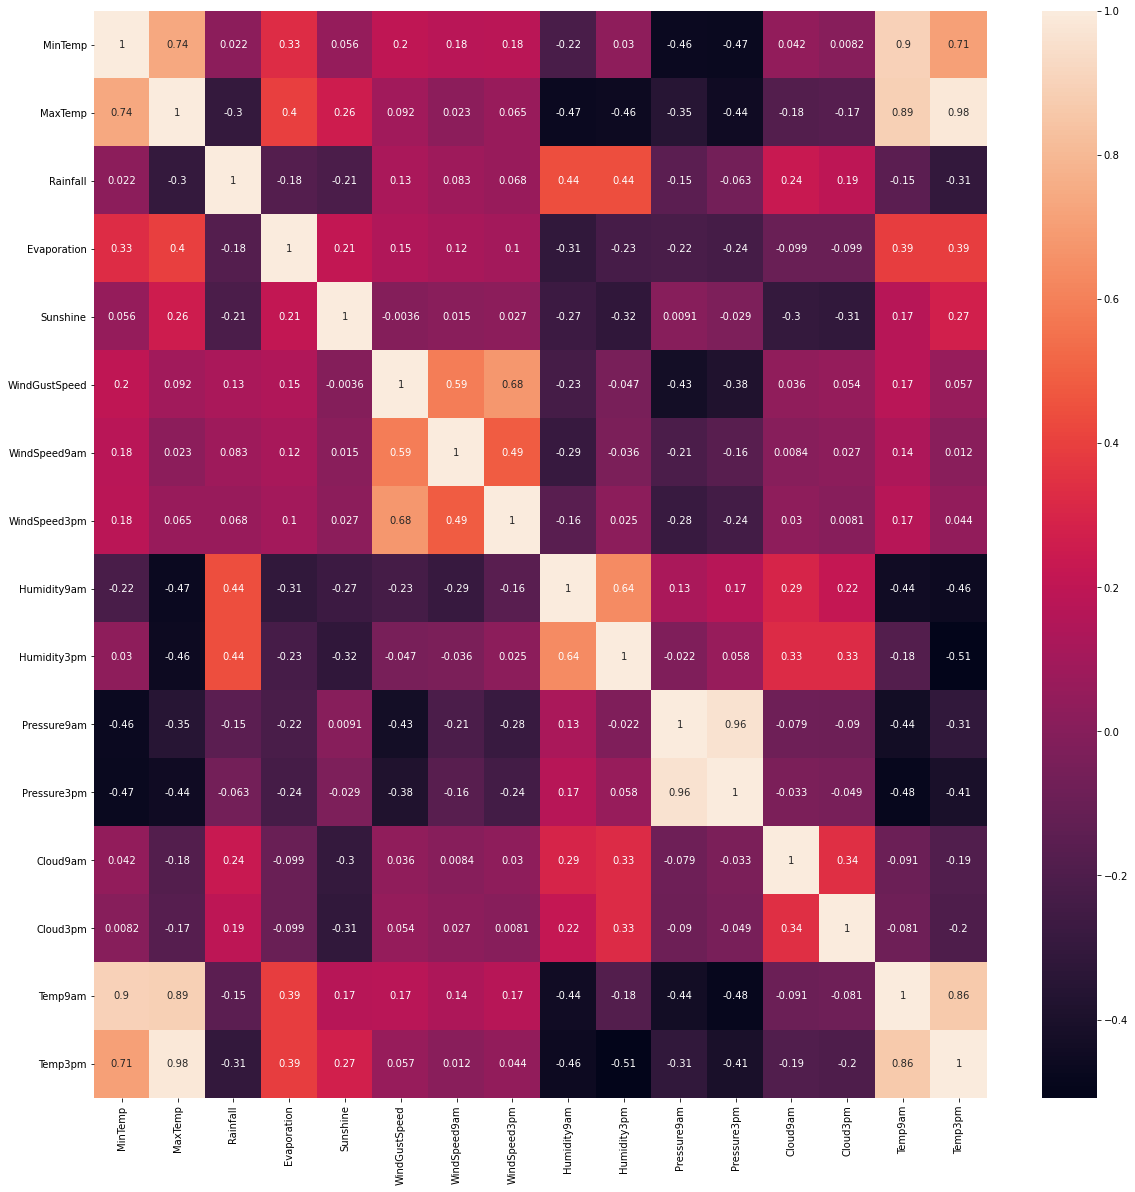

In [17]:
corrmat = df.corr(method='spearman')
plt.figure(figsize=(20,20))
sns.heatmap(corrmat,annot=True)

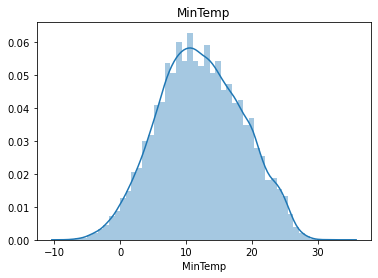

<Figure size 1080x1080 with 0 Axes>

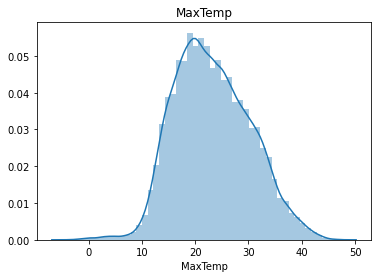

<Figure size 1080x1080 with 0 Axes>

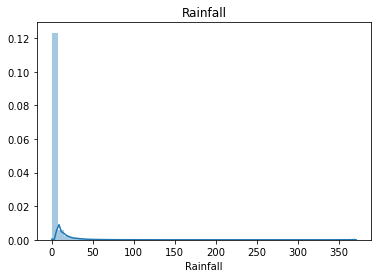

<Figure size 1080x1080 with 0 Axes>

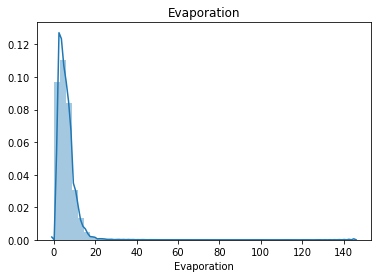

<Figure size 1080x1080 with 0 Axes>

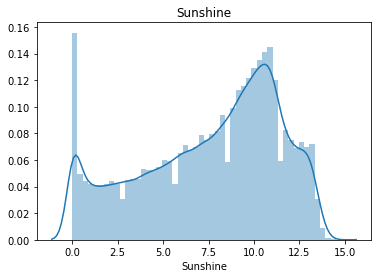

<Figure size 1080x1080 with 0 Axes>

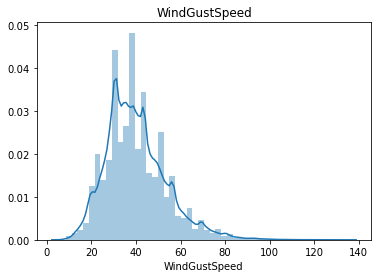

<Figure size 1080x1080 with 0 Axes>

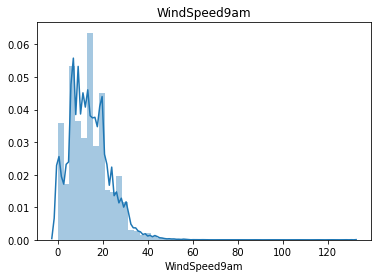

<Figure size 1080x1080 with 0 Axes>

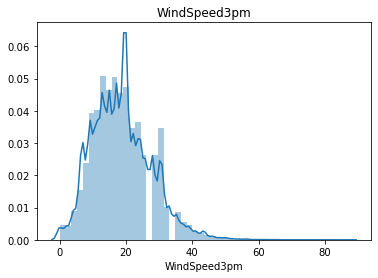

<Figure size 1080x1080 with 0 Axes>

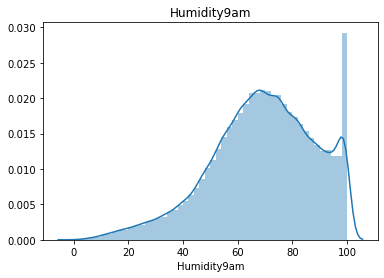

<Figure size 1080x1080 with 0 Axes>

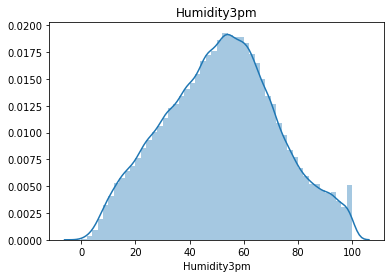

<Figure size 1080x1080 with 0 Axes>

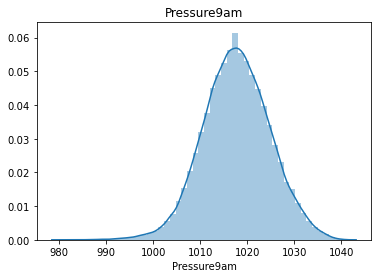

<Figure size 1080x1080 with 0 Axes>

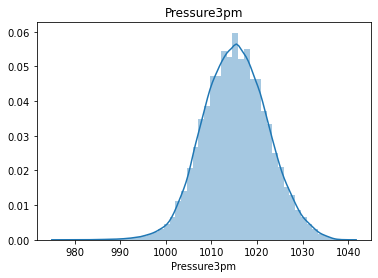

<Figure size 1080x1080 with 0 Axes>

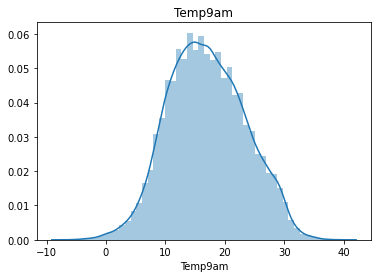

<Figure size 1080x1080 with 0 Axes>

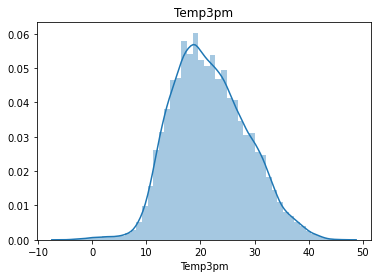

<Figure size 1080x1080 with 0 Axes>

In [37]:
# Data distribution of continous feature
for feature in continuous_feature:
    data = df.copy()
    sns.distplot(df[feature])
    plt.title(feature)
    plt.figure(figsize=(15,15))
    plt.show()

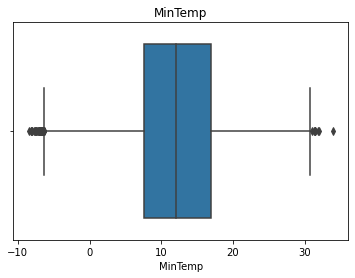

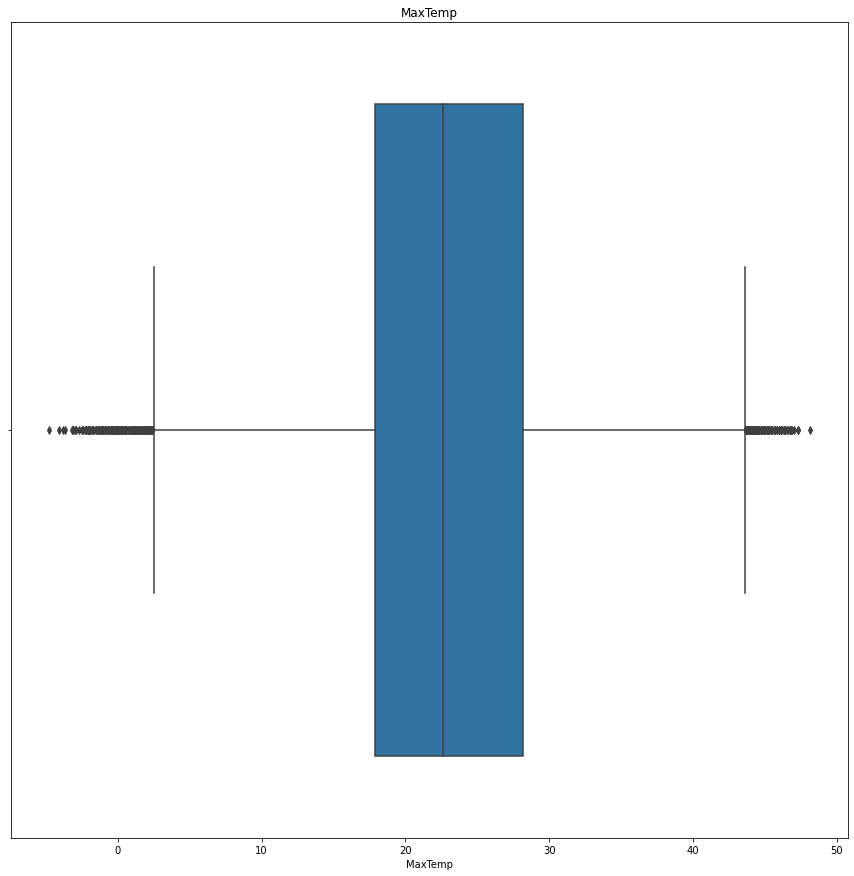

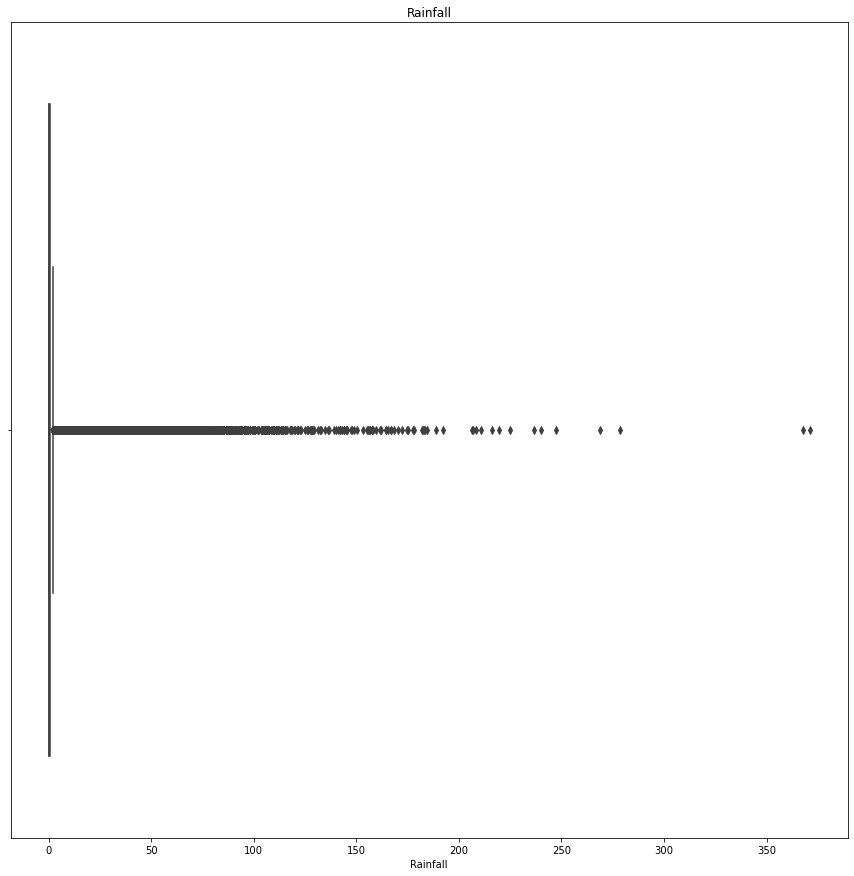

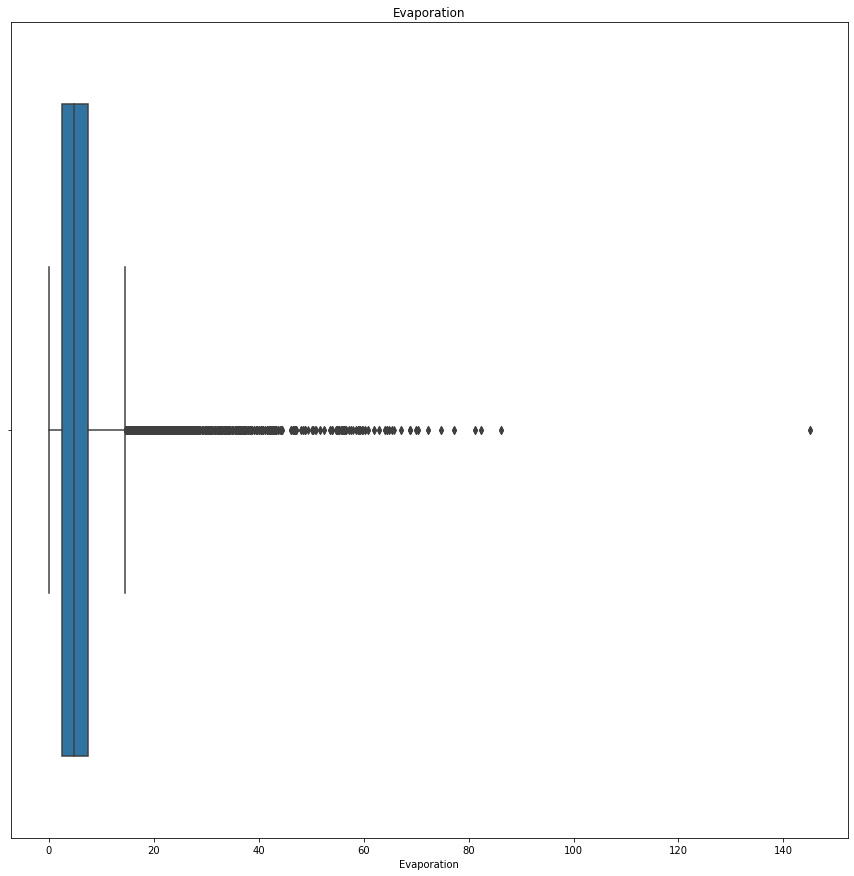

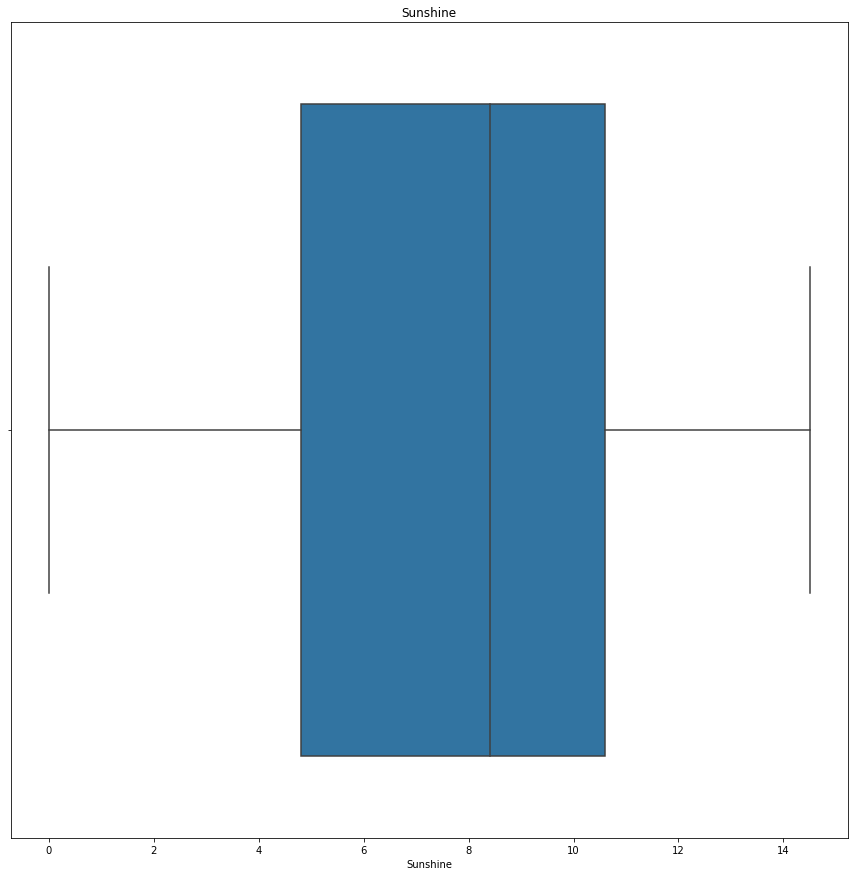

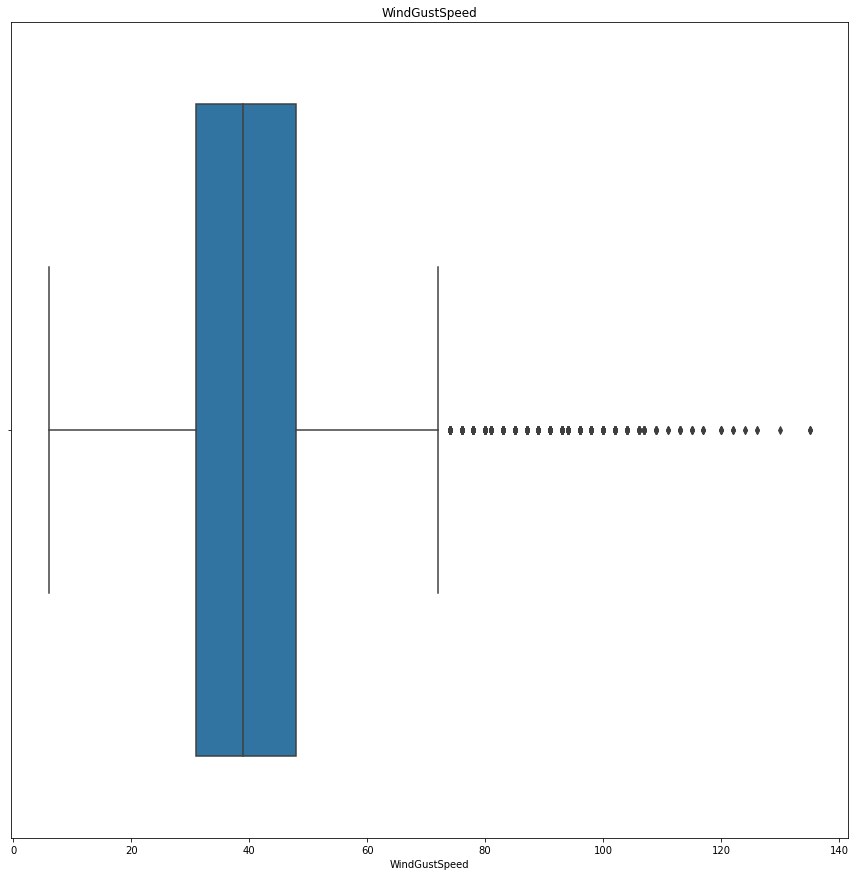

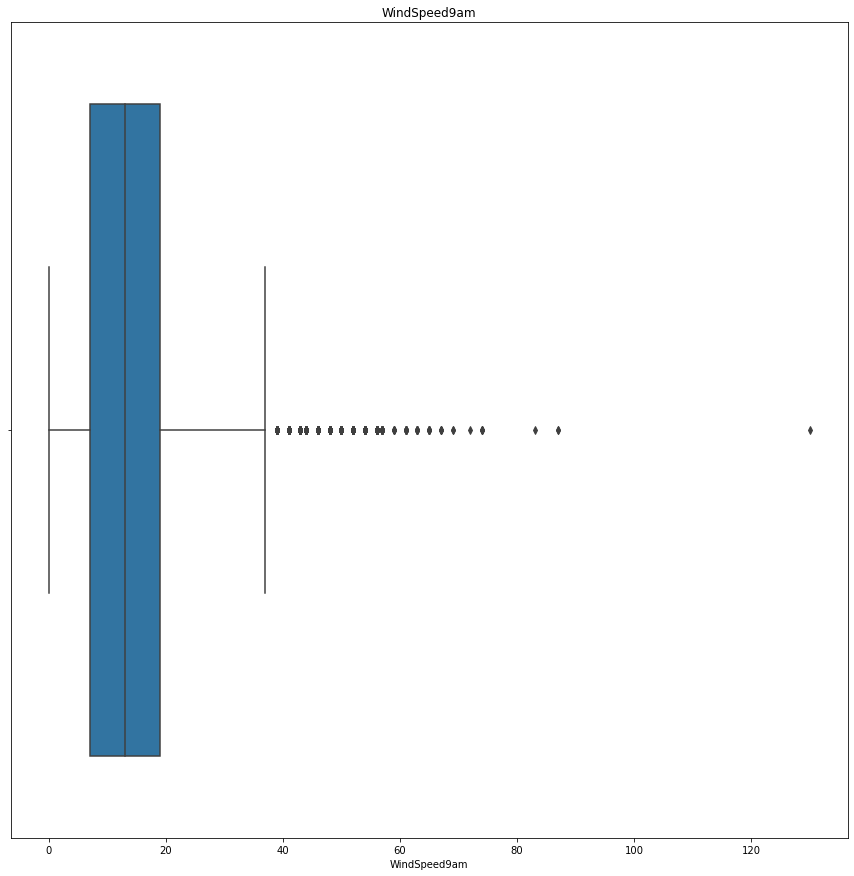

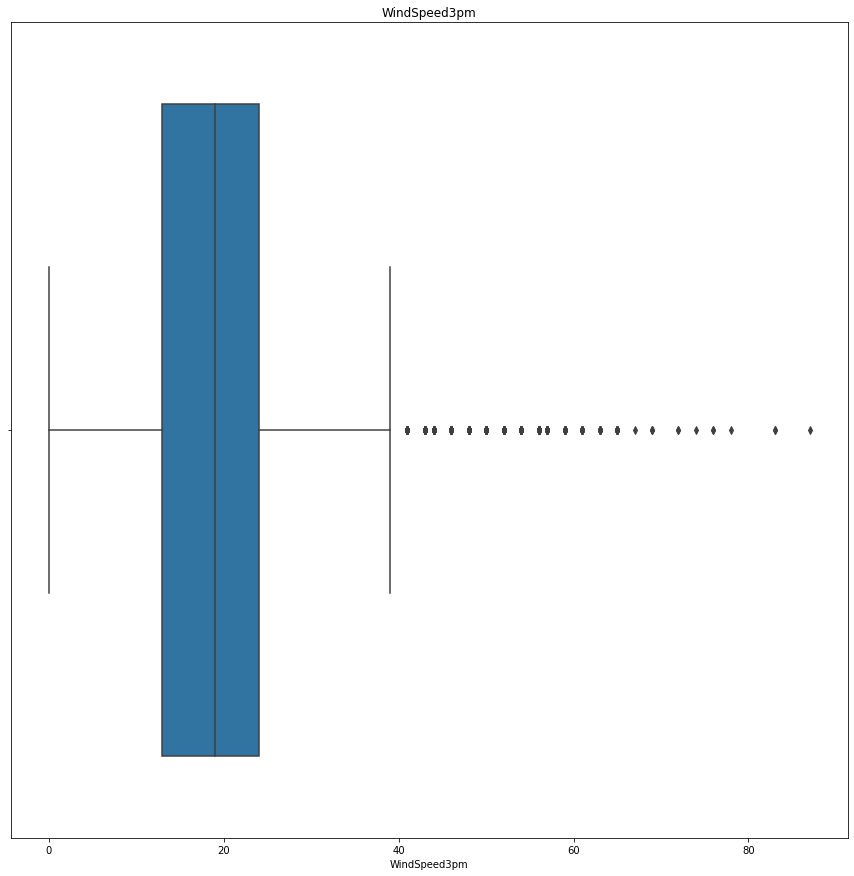

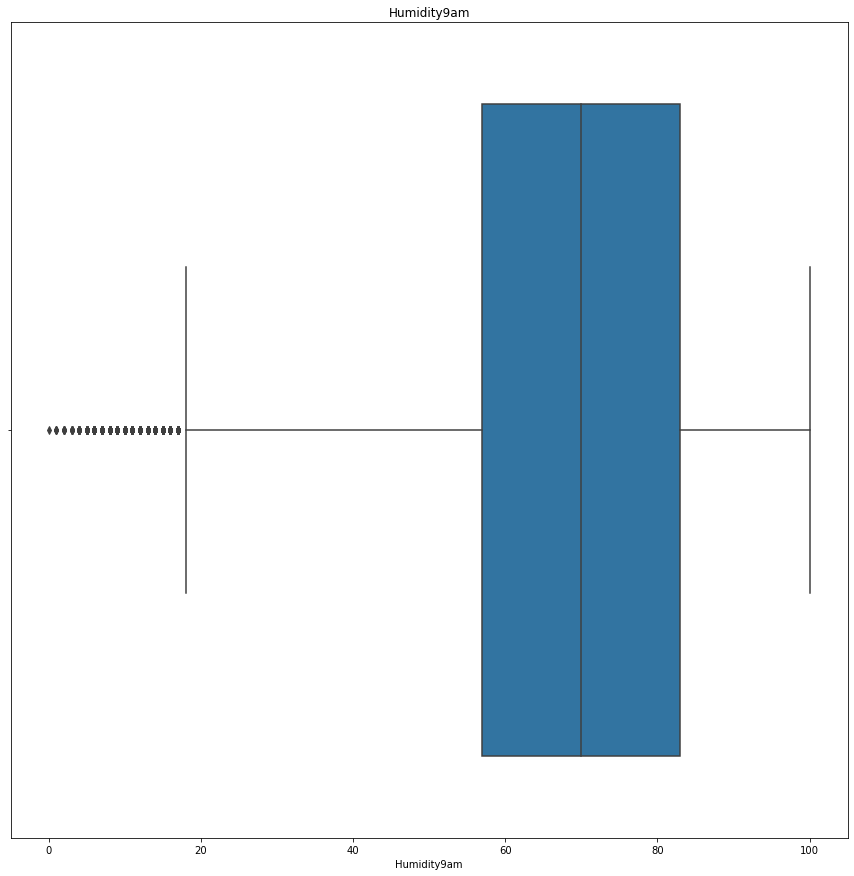

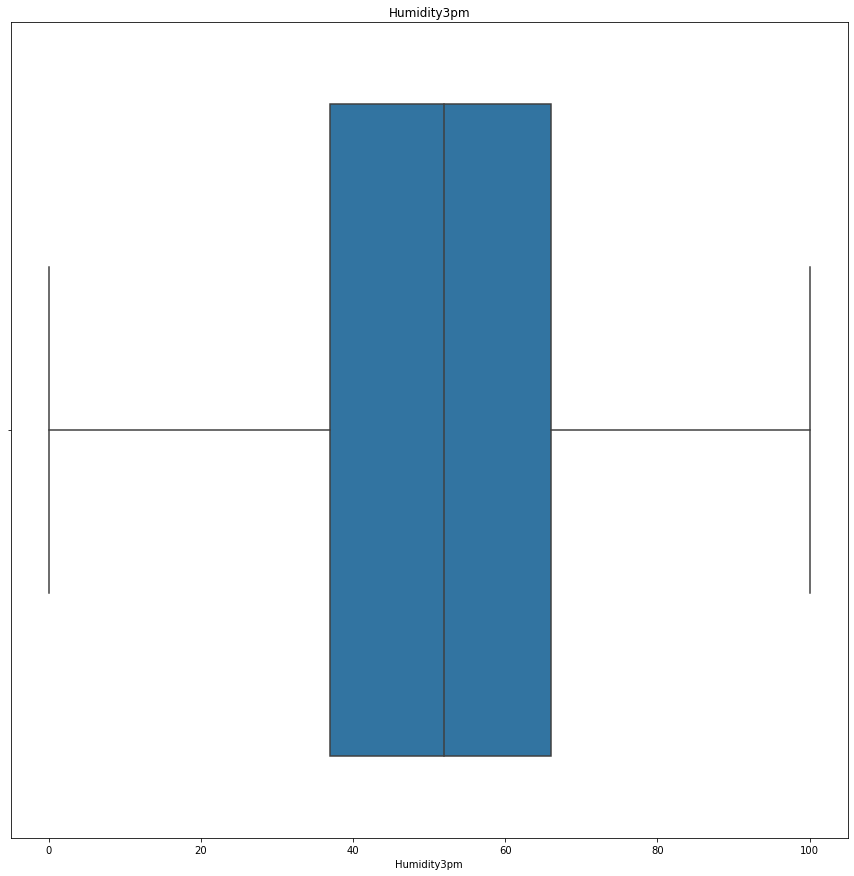

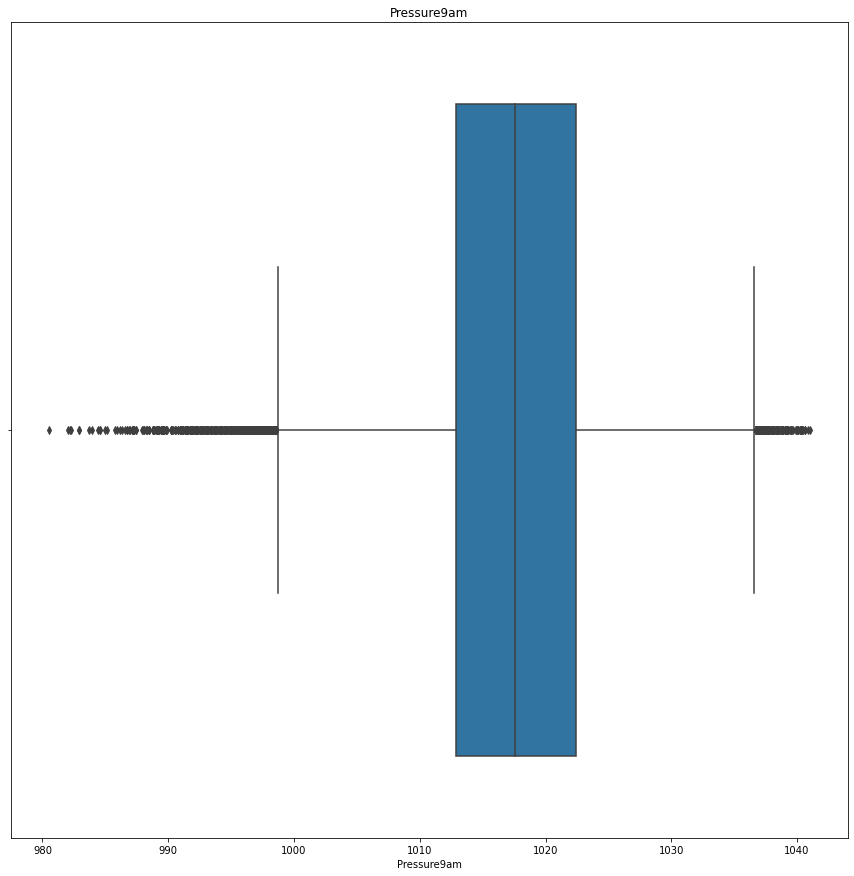

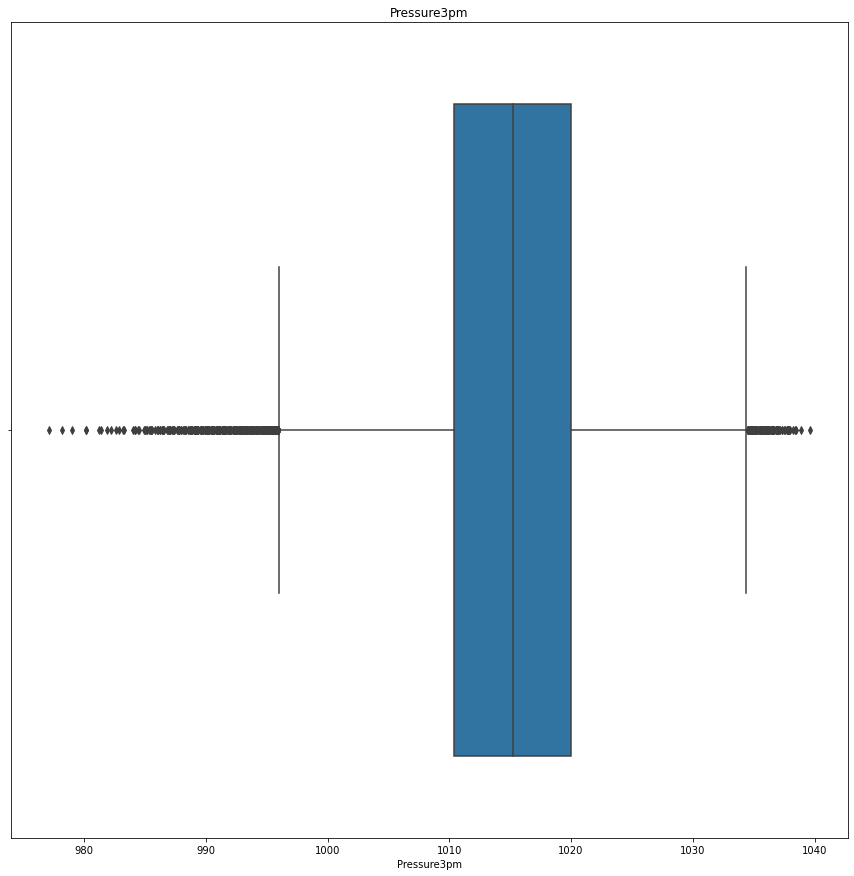

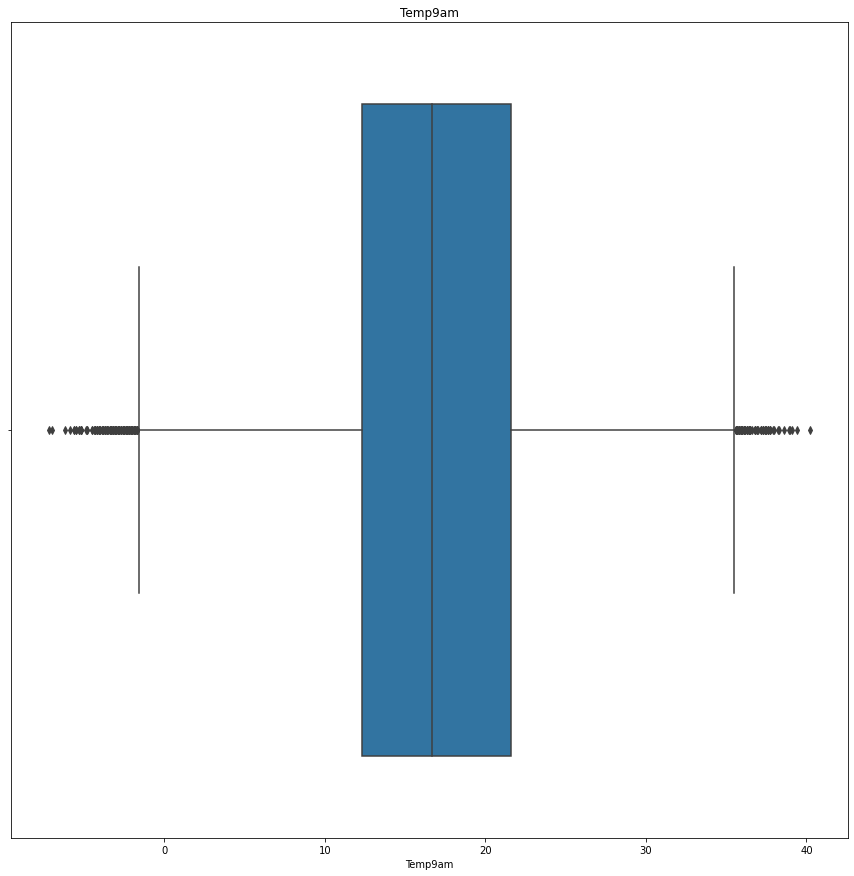

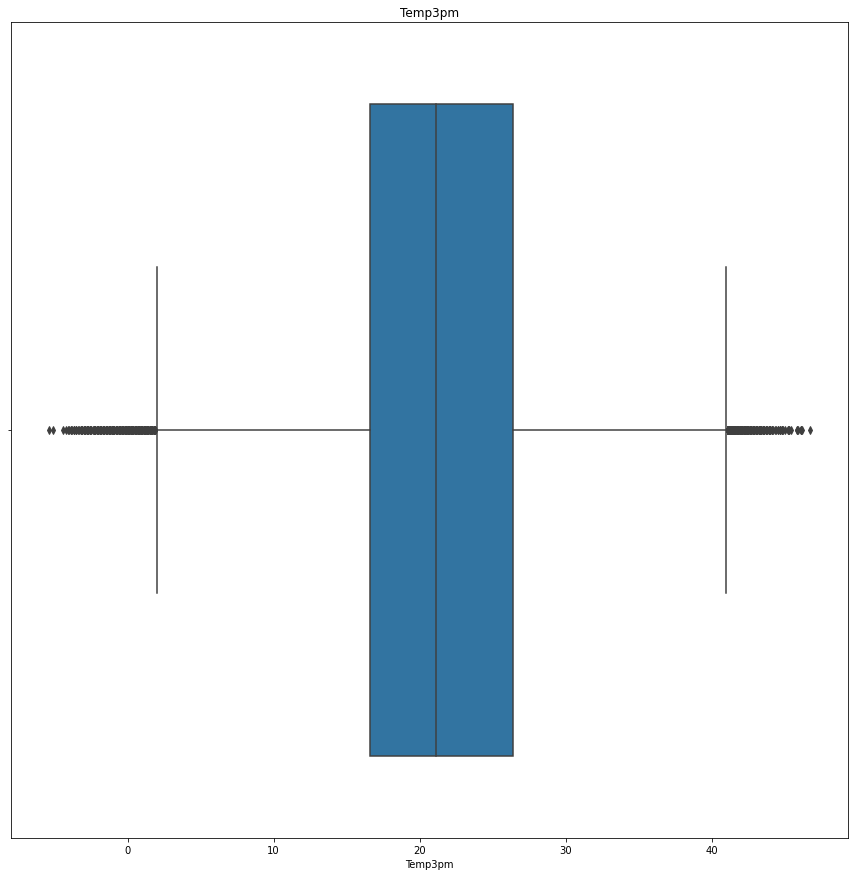

<Figure size 1080x1080 with 0 Axes>

In [29]:
# Checking the outliers in continous feature
for feature in continuous_feature:
    data = df.copy()
    sns.boxplot(data[feature])
    plt.title(feature)
    plt.figure(figsize=(15,15))

In [40]:
for feature in continuous_feature:
    if(df[feature].isnull().sum()*100/len(df))>0:
        df[feature]=df[feature].fillna(df[feature].median())

In [41]:
df.isnull().sum()*100/len(df)

Date             0.000000
Location         0.000000
MinTemp          0.000000
MaxTemp          0.000000
Rainfall         0.000000
Evaporation      0.000000
Sunshine         0.000000
WindGustDir      7.098859
WindGustSpeed    0.000000
WindDir9am       7.263853
WindDir3pm       2.906641
WindSpeed9am     0.000000
WindSpeed3pm     0.000000
Humidity9am      0.000000
Humidity3pm      0.000000
Pressure9am      0.000000
Pressure3pm      0.000000
Cloud9am         0.000000
Cloud3pm         0.000000
Temp9am          0.000000
Temp3pm          0.000000
RainToday        2.241853
RainTomorrow     2.245978
dtype: float64

In [42]:
def mode_nan(df,variable):
    mode=df[variable].value_counts().index[0]
    df[variable].fillna(mode,inplace=True)
mode_nan(df,"Cloud9am")
mode_nan(df,"Cloud3pm")

In [43]:
df["RainToday"]=pd.get_dummies(df["RainToday"],drop_first=True)
df["RainTomorrow"]=pd.get_dummies(df["RainTomorrow"],drop_first=True)
df

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,2.4,8.3,W,44.0,W,...,71.0,22.0,1007.7,1007.1,8.0,0.0,16.9,21.8,0,0
1,2008-12-02,Albury,7.4,25.1,0.0,3.6,10.0,WNW,44.0,NNW,...,44.0,25.0,1010.6,1007.8,7.0,1.0,17.2,24.3,0,0
2,2008-12-03,Albury,12.9,25.7,0.0,2.6,4.4,WSW,46.0,W,...,38.0,30.0,1007.6,1008.7,8.0,2.0,21.0,23.2,0,0
3,2008-12-04,Albury,9.2,28.0,0.0,18.4,8.9,NE,24.0,SE,...,45.0,16.0,1017.6,1012.8,0.0,5.0,18.1,26.5,0,0
4,2008-12-05,Albury,17.5,32.3,1.0,5.4,3.0,W,41.0,ENE,...,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145455,2017-06-21,Uluru,2.8,23.4,0.0,1.4,7.8,E,31.0,SE,...,51.0,24.0,1024.6,1020.3,1.0,1.0,10.1,22.4,0,0
145456,2017-06-22,Uluru,3.6,25.3,0.0,7.6,13.5,NNW,22.0,SE,...,56.0,21.0,1023.5,1019.1,8.0,5.0,10.9,24.5,0,0
145457,2017-06-23,Uluru,5.4,26.9,0.0,6.8,11.0,N,37.0,SE,...,53.0,24.0,1021.0,1016.8,8.0,1.0,12.5,26.1,0,0
145458,2017-06-24,Uluru,7.8,27.0,0.0,2.6,13.2,SE,28.0,SSE,...,51.0,24.0,1019.4,1016.5,3.0,2.0,15.1,26.0,0,0


In [45]:
for feature in categorical_feature:
      print(feature, (df.groupby([feature])["RainTomorrow"].mean().sort_values(ascending = False)).index)

Date Index(['2007-11-01', '2008-01-19', '2007-12-07', '2007-12-15', '2007-12-16',
       '2007-12-19', '2007-12-20', '2007-12-21', '2007-12-22', '2007-12-24',
       ...
       '2008-05-02', '2008-05-01', '2008-04-30', '2008-04-29', '2008-04-28',
       '2008-04-26', '2008-04-25', '2016-11-26', '2012-04-07', '2008-08-17'],
      dtype='object', name='Date', length=3436)
Location Index(['Portland', 'Walpole', 'Cairns', 'Dartmoor', 'NorfolkIsland',
       'MountGambier', 'Albany', 'Witchcliffe', 'CoffsHarbour', 'MountGinini',
       'NorahHead', 'Darwin', 'Sydney', 'SydneyAirport', 'Ballarat',
       'GoldCoast', 'Watsonia', 'Newcastle', 'Hobart', 'Wollongong',
       'Williamtown', 'Launceston', 'Brisbane', 'MelbourneAirport', 'Adelaide',
       'Sale', 'Albury', 'Perth', 'Melbourne', 'Nuriootpa', 'Penrith',
       'BadgerysCreek', 'PerthAirport', 'Tuggeranong', 'Richmond', 'Bendigo',
       'Canberra', 'WaggaWagga', 'Townsville', 'Katherine', 'PearceRAAF',
       'SalmonGums', 'Nhil', 

In [46]:
windgustdir = {'NNW':0, 'NW':1, 'WNW':2, 'N':3, 'W':4, 'WSW':5, 'NNE':6, 'S':7, 'SSW':8, 'SW':9, 'SSE':10,
       'NE':11, 'SE':12, 'ESE':13, 'ENE':14, 'E':15}
winddir9am = {'NNW':0, 'N':1, 'NW':2, 'NNE':3, 'WNW':4, 'W':5, 'WSW':6, 'SW':7, 'SSW':8, 'NE':9, 'S':10,
       'SSE':11, 'ENE':12, 'SE':13, 'ESE':14, 'E':15}
winddir3pm = {'NW':0, 'NNW':1, 'N':2, 'WNW':3, 'W':4, 'NNE':5, 'WSW':6, 'SSW':7, 'S':8, 'SW':9, 'SE':10,
       'NE':11, 'SSE':12, 'ENE':13, 'E':14, 'ESE':15}

df["WindGustDir"] = df["WindGustDir"].map(windgustdir)
df["WindDir9am"] = df["WindDir9am"].map(winddir9am)
df["WindDir3pm"] = df["WindDir3pm"].map(winddir3pm)

In [50]:
df["WindGustDir"] = df["WindGustDir"].fillna(df["WindGustDir"].value_counts().index[0])
df["WindDir9am"] = df["WindDir9am"].fillna(df["WindDir9am"].value_counts().index[0])
df["WindDir3pm"] = df["WindDir3pm"].fillna(df["WindDir3pm"].value_counts().index[0])

In [51]:
df.isnull().sum()*100/len(df)

Date             0.0
Location         0.0
MinTemp          0.0
MaxTemp          0.0
Rainfall         0.0
Evaporation      0.0
Sunshine         0.0
WindGustDir      0.0
WindGustSpeed    0.0
WindDir9am       0.0
WindDir3pm       0.0
WindSpeed9am     0.0
WindSpeed3pm     0.0
Humidity9am      0.0
Humidity3pm      0.0
Pressure9am      0.0
Pressure3pm      0.0
Cloud9am         0.0
Cloud3pm         0.0
Temp9am          0.0
Temp3pm          0.0
RainToday        0.0
RainTomorrow     0.0
dtype: float64

In [53]:
df1 = df.groupby(["Location"])["RainTomorrow"].value_counts().sort_values().unstack()

In [54]:
df1

RainTomorrow,0,1
Location,,
Adelaide,2505,688
Albany,2138,902
Albury,2422,618
AliceSprings,2796,244
BadgerysCreek,2426,583
Ballarat,2259,781
Bendigo,2478,562
Brisbane,2484,709
Cairns,2090,950


In [55]:
df1[1].sort_values(ascending = False)

Location
Portland            1095
Cairns               950
Walpole              949
Dartmoor             922
MountGambier         920
NorfolkIsland        919
Albany               902
Witchcliffe          879
CoffsHarbour         869
Sydney               865
Darwin               852
MountGinini          819
NorahHead            808
Ballarat             781
GoldCoast            775
SydneyAirport        774
Hobart               761
Watsonia             738
Newcastle            731
Wollongong           713
Brisbane             709
Williamtown          700
Launceston           699
Adelaide             688
MelbourneAirport     653
Perth                645
Sale                 643
Melbourne            636
Canberra             629
Albury               618
Penrith              595
Nuriootpa            592
BadgerysCreek        583
Tuggeranong          568
PerthAirport         567
Bendigo              562
Richmond             560
WaggaWagga           536
Townsville           519
PearceRAAF      

In [56]:
df1[1].sort_values(ascending = False).index

Index(['Portland', 'Cairns', 'Walpole', 'Dartmoor', 'MountGambier',
       'NorfolkIsland', 'Albany', 'Witchcliffe', 'CoffsHarbour', 'Sydney',
       'Darwin', 'MountGinini', 'NorahHead', 'Ballarat', 'GoldCoast',
       'SydneyAirport', 'Hobart', 'Watsonia', 'Newcastle', 'Wollongong',
       'Brisbane', 'Williamtown', 'Launceston', 'Adelaide', 'MelbourneAirport',
       'Perth', 'Sale', 'Melbourne', 'Canberra', 'Albury', 'Penrith',
       'Nuriootpa', 'BadgerysCreek', 'Tuggeranong', 'PerthAirport', 'Bendigo',
       'Richmond', 'WaggaWagga', 'Townsville', 'PearceRAAF', 'SalmonGums',
       'Moree', 'Cobar', 'Mildura', 'Katherine', 'AliceSprings', 'Nhil',
       'Woomera', 'Uluru'],
      dtype='object', name='Location')

In [57]:
len(df1[1].sort_values(ascending = False).index)

49

In [58]:
location = {'Portland':1, 'Cairns':2, 'Walpole':3, 'Dartmoor':4, 'MountGambier':5,
       'NorfolkIsland':6, 'Albany':7, 'Witchcliffe':8, 'CoffsHarbour':9, 'Sydney':10,
       'Darwin':11, 'MountGinini':12, 'NorahHead':13, 'Ballarat':14, 'GoldCoast':15,
       'SydneyAirport':16, 'Hobart':17, 'Watsonia':18, 'Newcastle':19, 'Wollongong':20,
       'Brisbane':21, 'Williamtown':22, 'Launceston':23, 'Adelaide':24, 'MelbourneAirport':25,
       'Perth':26, 'Sale':27, 'Melbourne':28, 'Canberra':29, 'Albury':30, 'Penrith':31,
       'Nuriootpa':32, 'BadgerysCreek':33, 'Tuggeranong':34, 'PerthAirport':35, 'Bendigo':36,
       'Richmond':37, 'WaggaWagga':38, 'Townsville':39, 'PearceRAAF':40, 'SalmonGums':41,
       'Moree':42, 'Cobar':43, 'Mildura':44, 'Katherine':45, 'AliceSprings':46, 'Nhil':47,
       'Woomera':48, 'Uluru':49}


df["Location"] = df["Location"].map(location)

In [59]:
df["Date"] = pd.to_datetime(df["Date"], format = "%Y-%m-%dT", errors = "coerce")

In [60]:
df["Date_month"] = df["Date"].dt.month
df["Date_day"] = df["Date"].dt.day

In [63]:
df

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,Date_month,Date_day
0,2008-12-01,30,13.4,22.9,0.6,2.4,8.3,4.0,44.0,5.0,...,1007.7,1007.1,8.0,0.0,16.9,21.8,0,0,12,1
1,2008-12-02,30,7.4,25.1,0.0,3.6,10.0,2.0,44.0,0.0,...,1010.6,1007.8,7.0,1.0,17.2,24.3,0,0,12,2
2,2008-12-03,30,12.9,25.7,0.0,2.6,4.4,5.0,46.0,5.0,...,1007.6,1008.7,8.0,2.0,21.0,23.2,0,0,12,3
3,2008-12-04,30,9.2,28.0,0.0,18.4,8.9,11.0,24.0,13.0,...,1017.6,1012.8,0.0,5.0,18.1,26.5,0,0,12,4
4,2008-12-05,30,17.5,32.3,1.0,5.4,3.0,4.0,41.0,12.0,...,1010.8,1006.0,7.0,8.0,17.8,29.7,0,0,12,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145455,2017-06-21,49,2.8,23.4,0.0,1.4,7.8,15.0,31.0,13.0,...,1024.6,1020.3,1.0,1.0,10.1,22.4,0,0,6,21
145456,2017-06-22,49,3.6,25.3,0.0,7.6,13.5,0.0,22.0,13.0,...,1023.5,1019.1,8.0,5.0,10.9,24.5,0,0,6,22
145457,2017-06-23,49,5.4,26.9,0.0,6.8,11.0,3.0,37.0,13.0,...,1021.0,1016.8,8.0,1.0,12.5,26.1,0,0,6,23
145458,2017-06-24,49,7.8,27.0,0.0,2.6,13.2,12.0,28.0,11.0,...,1019.4,1016.5,3.0,2.0,15.1,26.0,0,0,6,24


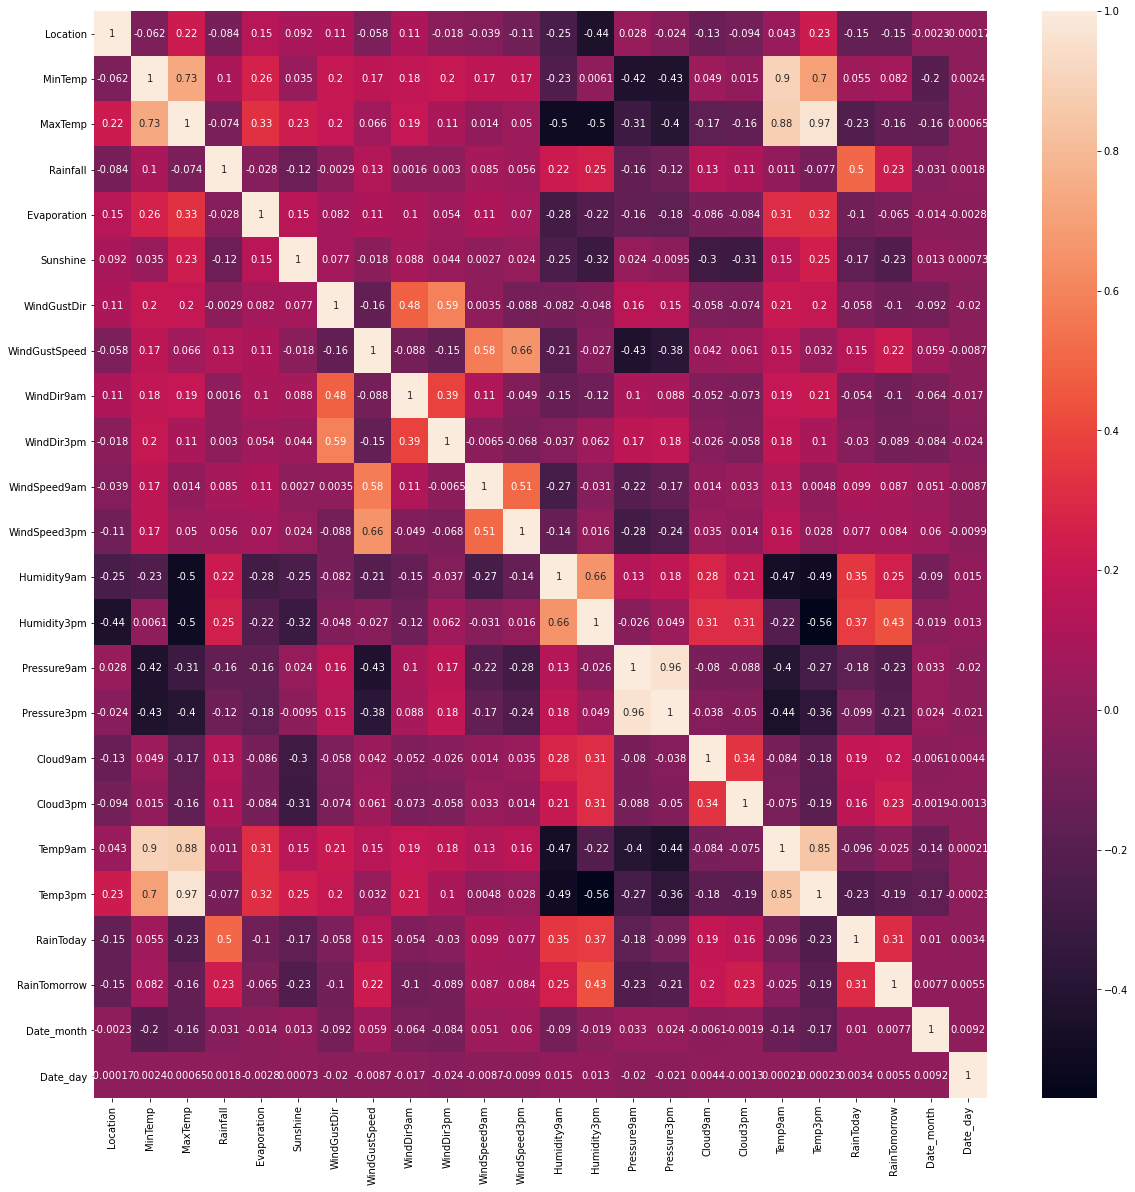

In [64]:
#Again Checking the correlation
corrmat = df.corr()
plt.figure(figsize=(20,20))
g=sns.heatmap(corrmat,annot=True)

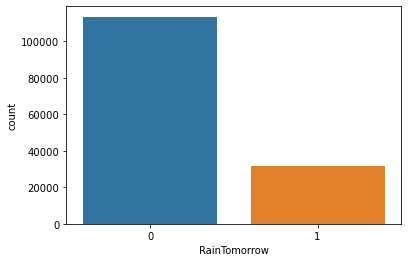

In [65]:
sns.countplot(df["RainTomorrow"])

In [66]:
for feature in continuous_feature:
    print(feature)

MinTemp
MaxTemp
Rainfall
Evaporation
Sunshine
WindGustSpeed
WindSpeed9am
WindSpeed3pm
Humidity9am
Humidity3pm
Pressure9am
Pressure3pm
Temp9am
Temp3pm


In [67]:
IQR = df.MinTemp.quantile(0.75)-df.MinTemp.quantile(0.25)
lower_bridge = df.MinTemp.quantile(0.25)-(IQR*1.5)
upper_bridge= df.MinTemp.quantile(0.75)+(IQR*1.5)
print(lower_bridge)
print(upper_bridge)

-5.950000000000002
30.450000000000003


In [68]:
df.loc[df['MinTemp']>=30.45,'MinTemp']=30.45
df.loc[df['MinTemp']<=-5.95,'MinTemp']=-5.95

In [70]:
IQR=df.MaxTemp.quantile(0.75)-df.MaxTemp.quantile(0.25)
lower_bridge=df.MaxTemp.quantile(0.25)-(IQR*1.5)
upper_bridge=df.MaxTemp.quantile(0.75)+(IQR*1.5)
print(lower_bridge)
print(upper_bridge)

2.700000000000001
43.5


In [71]:
df.loc[df['MaxTemp']>=43.5,'MaxTemp']=43.5
df.loc[df['MaxTemp']<=2.7,'MaxTemp']=2.7

In [73]:
IQR=df.Rainfall.quantile(0.75)-df.Rainfall.quantile(0.25)
lower_bridge=df.Rainfall.quantile(0.25)-(IQR*1.5)
upper_bridge=df.Rainfall.quantile(0.75)+(IQR*1.5)
print(lower_bridge)
print(upper_bridge)

-0.8999999999999999
1.5


In [74]:
df.loc[df['Rainfall']>=1.5,'Rainfall']=1.5
df.loc[df['Rainfall']<=-0.89,'Rainfall']=-0.89

In [75]:
IQR=df.Evaporation.quantile(0.75)-df.Evaporation.quantile(0.25)
lower_bridge=df.Evaporation.quantile(0.25)-(IQR*1.5)
upper_bridge=df.Evaporation.quantile(0.75)+(IQR*1.5)
print(lower_bridge)
print(upper_bridge)

-4.600000000000001
14.600000000000001


In [76]:
df.loc[df['Evaporation']>=14.6,'Evaporation']=14.6
df.loc[df['Evaporation']<=-4.6,'Evaporation']=-4.6

In [77]:
IQR=df.WindGustSpeed.quantile(0.75)-df.WindGustSpeed.quantile(0.25)
lower_bridge=df.WindGustSpeed.quantile(0.25)-(IQR*1.5)
upper_bridge=df.WindGustSpeed.quantile(0.75)+(IQR*1.5)
print(lower_bridge)
print(upper_bridge)

8.5
68.5


In [78]:
df.loc[df['WindGustSpeed']>=68.5,'WindGustSpeed']=68.5
df.loc[df['WindGustSpeed']<=8.5,'WindGustSpeed']=8.5

In [79]:
IQR=df.WindSpeed9am.quantile(0.75)-df.WindSpeed9am.quantile(0.25)
lower_bridge=df.WindSpeed9am.quantile(0.25)-(IQR*1.5)
upper_bridge=df.WindSpeed9am.quantile(0.75)+(IQR*1.5)
print(lower_bridge)
print(upper_bridge)

-11.0
37.0


In [80]:
df.loc[df['WindSpeed9am']>=37,'WindSpeed9am']=37
df.loc[df['WindSpeed9am']<=-11,'WindSpeed9am']=-11

In [81]:
IQR=df.WindSpeed3pm.quantile(0.75)-df.WindSpeed3pm.quantile(0.25)
lower_bridge=df.WindSpeed3pm.quantile(0.25)-(IQR*1.5)
upper_bridge=df.WindSpeed3pm.quantile(0.75)+(IQR*1.5)
print(lower_bridge)
print(upper_bridge)

-3.5
40.5


In [82]:
df.loc[df['WindSpeed3pm']>40.5,'WindSpeed3pm']=40.5
df.loc[df['WindSpeed3pm']<=-3.5,'WindSpeed3pm']=-3.5

In [83]:
IQR=df.Humidity9am.quantile(0.75)-df.Humidity9am.quantile(0.25)
lower_bridge=df.Humidity9am.quantile(0.25)-(IQR*1.5)
upper_bridge=df.Humidity9am.quantile(0.75)+(IQR*1.5)
print(lower_bridge)
print(upper_bridge)

18.0
122.0


In [84]:
df.loc[df['Humidity9am']>=122,'Humidity9am']=122
df.loc[df['Humidity9am']<=18,'Humidity9am']=18

In [85]:
IQR=df.Pressure9am.quantile(0.75)-df.Pressure9am.quantile(0.25)
lower_bridge=df.Pressure9am.quantile(0.25)-(IQR*1.5)
upper_bridge=df.Pressure9am.quantile(0.75)+(IQR*1.5)
print(lower_bridge) 
print(upper_bridge)

1001.0500000000001
1034.25


In [86]:
df.loc[df['Pressure9am']>=1034.25,'Pressure9am']=1034.25
df.loc[df['Pressure9am']<=1001.05,'Pressure9am']=1001.05

In [87]:
IQR=df.Pressure3pm.quantile(0.75)-df.Pressure3pm.quantile(0.25)
lower_bridge=df.Pressure3pm.quantile(0.25)-(IQR*1.5)
upper_bridge=df.Pressure3pm.quantile(0.75)+(IQR*1.5)
print(lower_bridge) 
print(upper_bridge)

998.6500000000001
1031.85


In [88]:
df.loc[df['Pressure3pm']>=1031.85,'Pressure3pm']=1031.85
df.loc[df['Pressure3pm']<=998.65,'Pressure3pm']=998.65

In [89]:
IQR=df.Temp9am.quantile(0.75)-df.Temp9am.quantile(0.25)
lower_bridge=df.Temp9am.quantile(0.25)-(IQR*1.5)
upper_bridge=df.Temp9am.quantile(0.75)+(IQR*1.5)
print(lower_bridge)
print(upper_bridge)

-1.4999999999999982
35.3


In [90]:
df.loc[df['Temp9am']>=35.3,'Temp9am']=35.3
df.loc[df['Temp9am']<=-1.49,'Temp9am']=-1.49

In [91]:
IQR=df.Temp3pm.quantile(0.75)-df.Temp3pm.quantile(0.25)
lower_bridge=df.Temp3pm.quantile(0.25)-(IQR*1.5)
upper_bridge=df.Temp3pm.quantile(0.75)+(IQR*1.5)
print(lower_bridge) 
print(upper_bridge)

2.4499999999999993
40.45


In [92]:
df.loc[df['Temp3pm']>=40.45,'Temp3pm']=40.45
df.loc[df['Temp3pm']<=2.45,'Temp3pm']=2.45

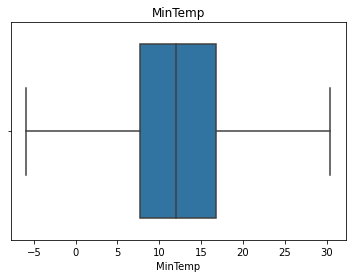

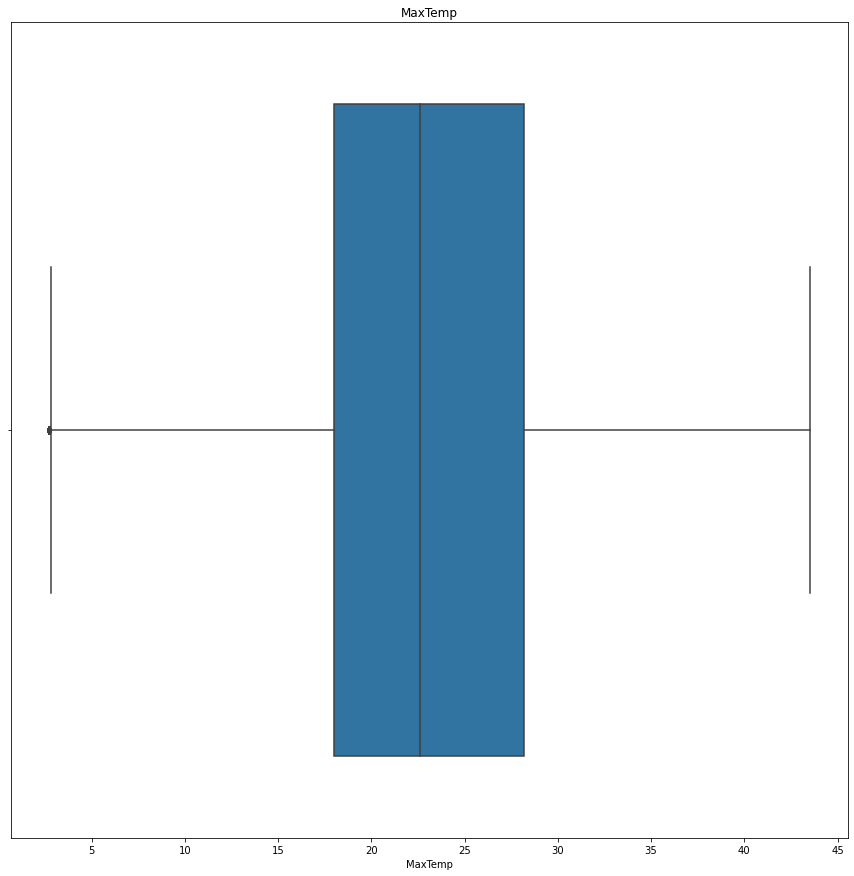

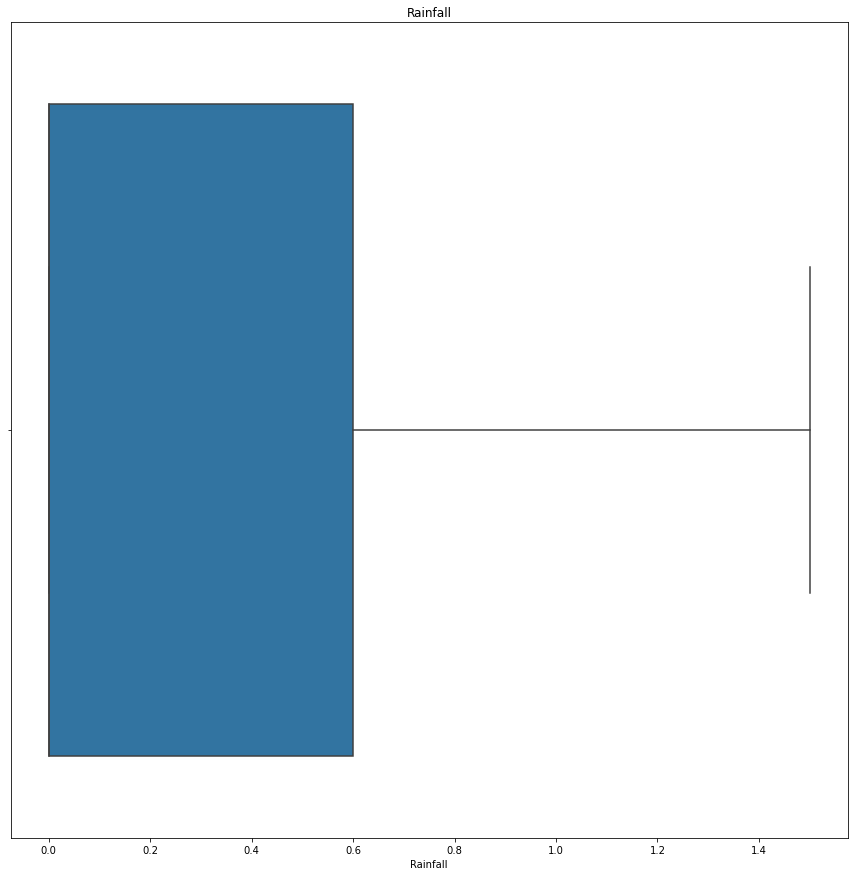

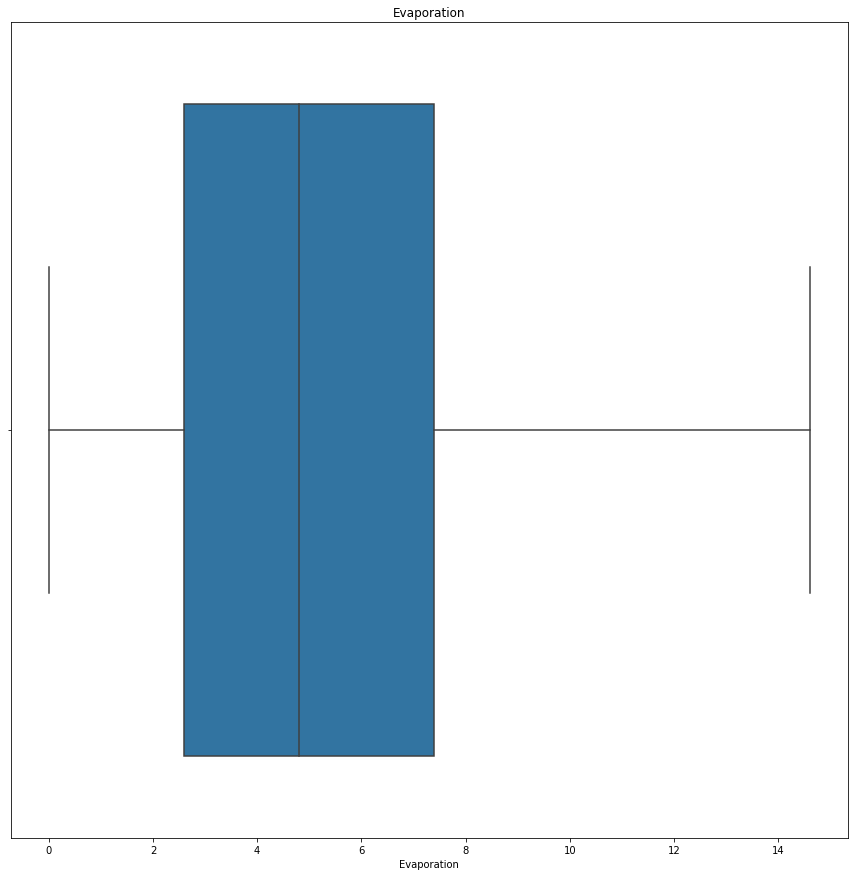

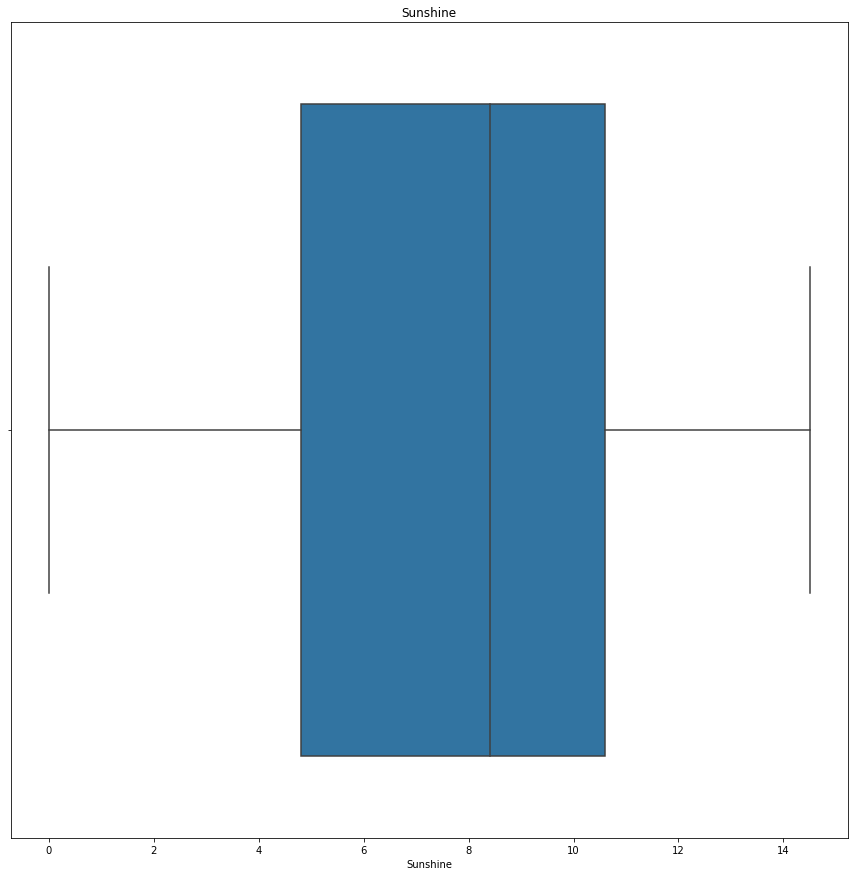

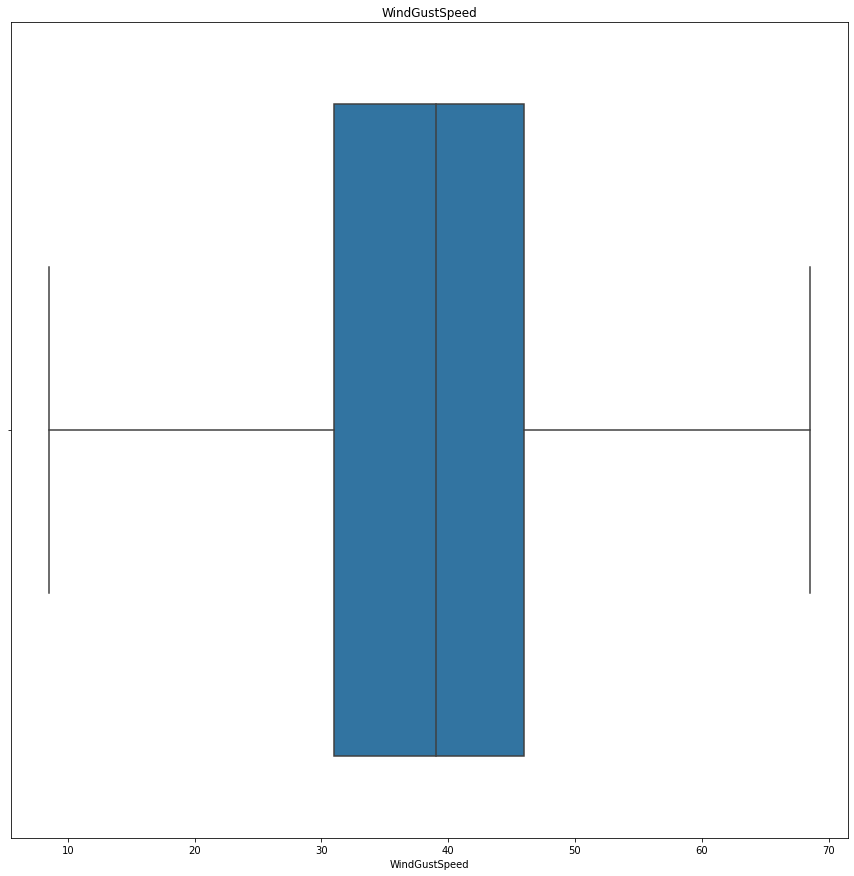

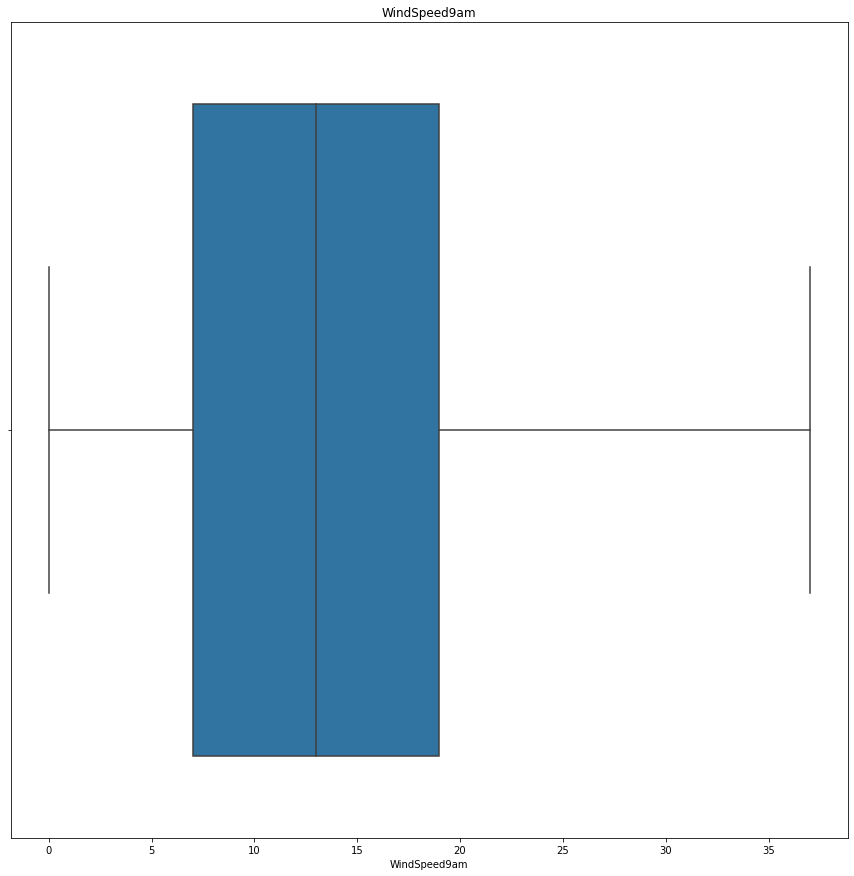

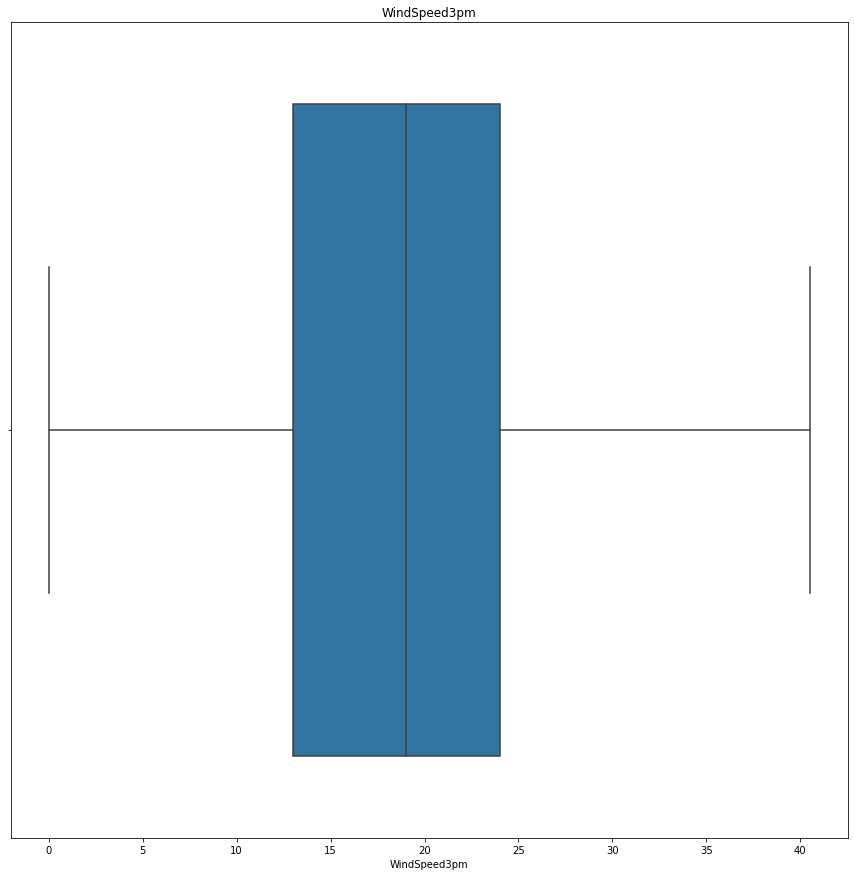

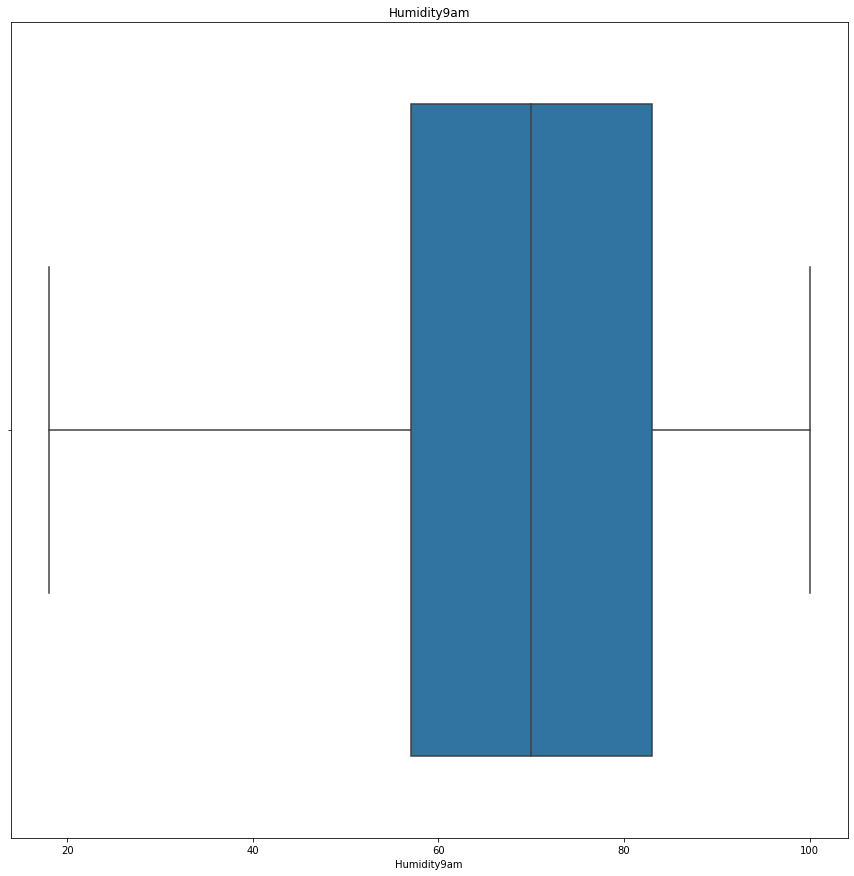

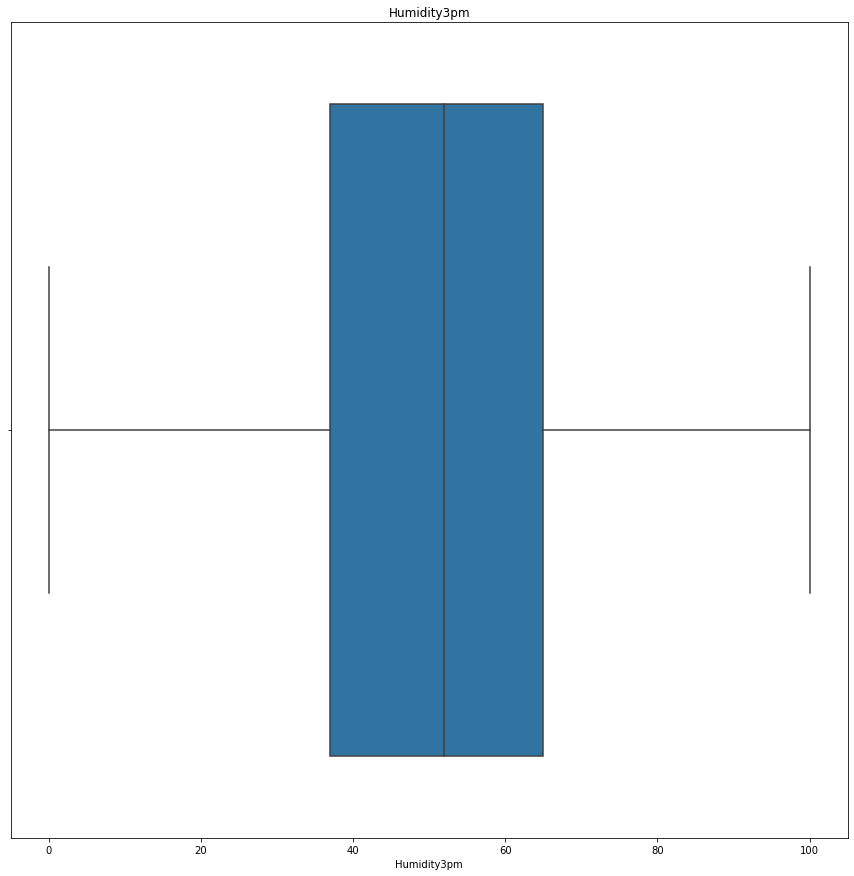

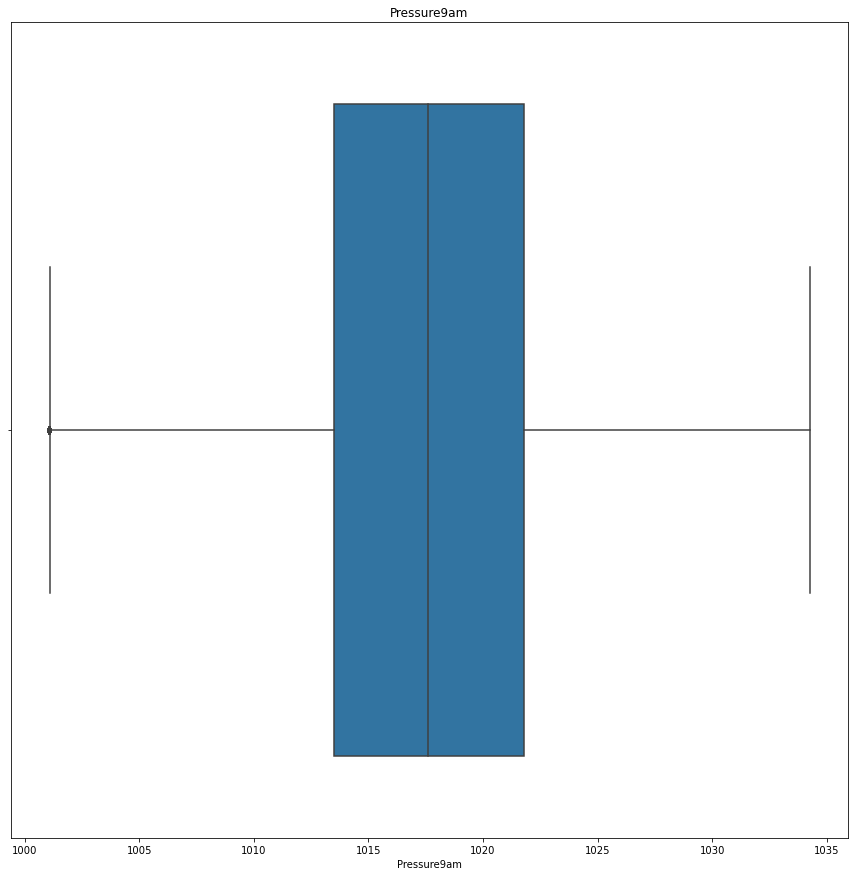

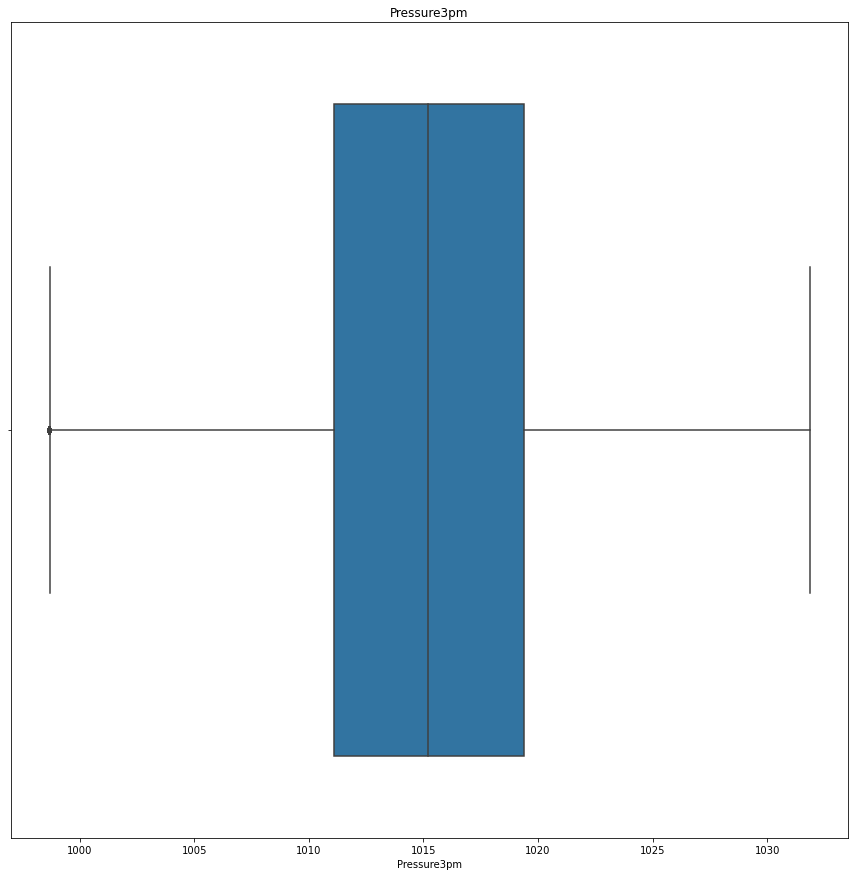

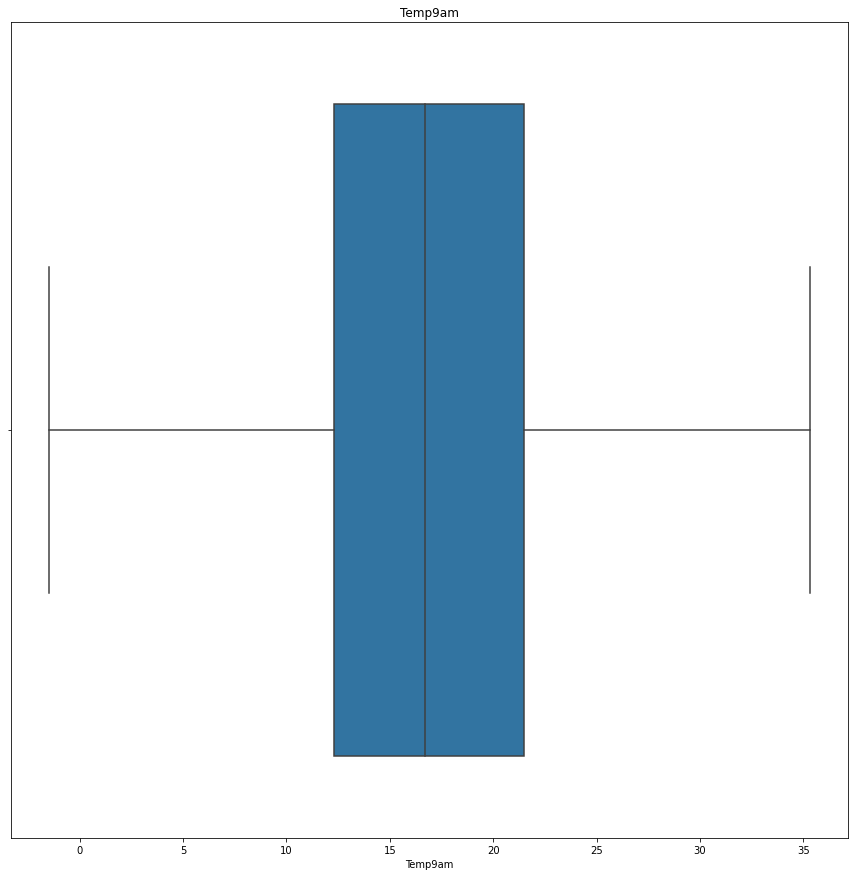

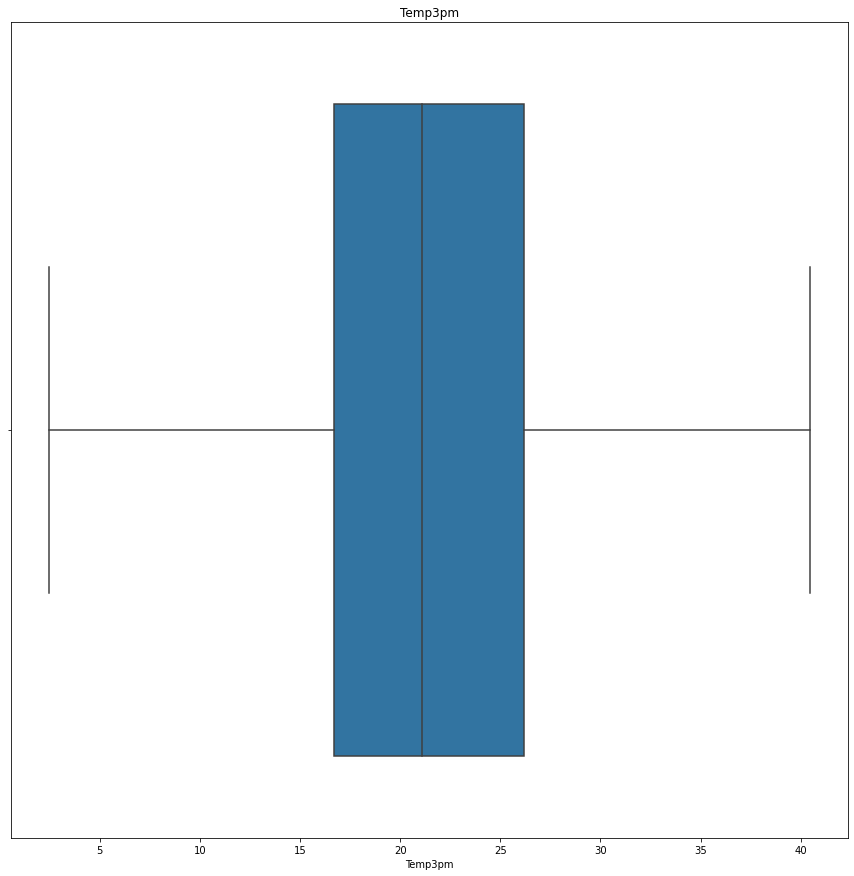

<Figure size 1080x1080 with 0 Axes>

In [93]:
for feature in continuous_feature:
    data=df.copy()
    sns.boxplot(data[feature])
    plt.title(feature)
    plt.figure(figsize=(15,15))

In [94]:
def qq_plots(df,variable):
    plt.figure(figsize=(15,6))
    plt.subplot(1,2,1)
    df[variable].hist()
    plt.subplot(1,2,2)
    stats.probplot(df[variable],dist="norm",plot=plt)
    plt.show()

MinTemp


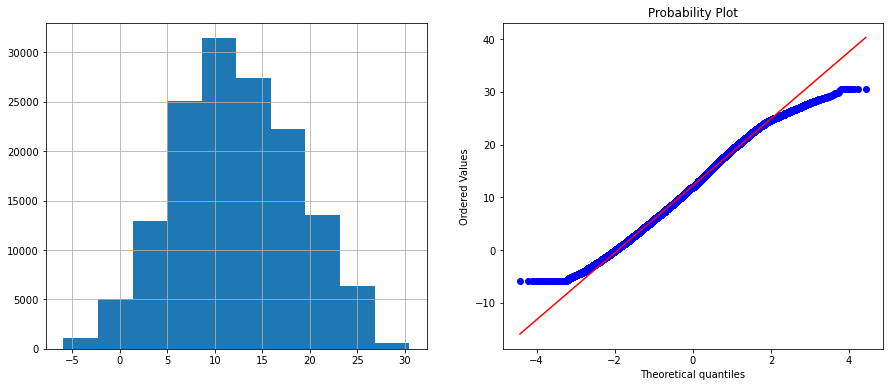

MaxTemp


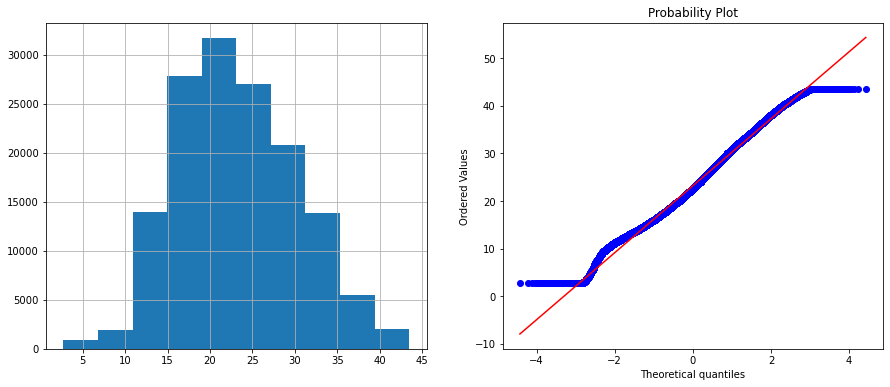

Rainfall


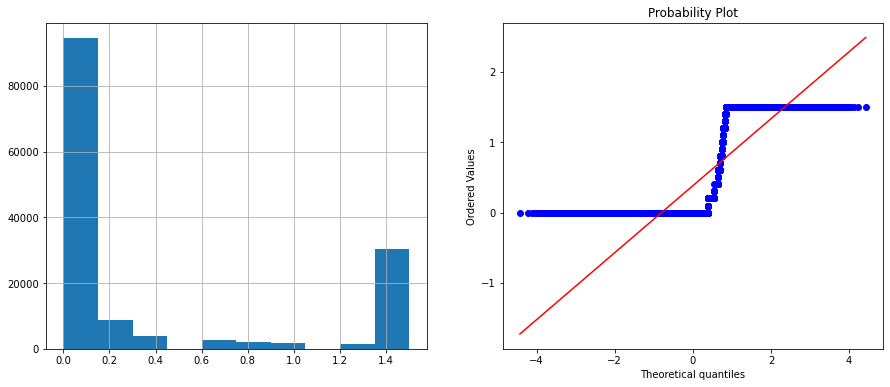

Evaporation


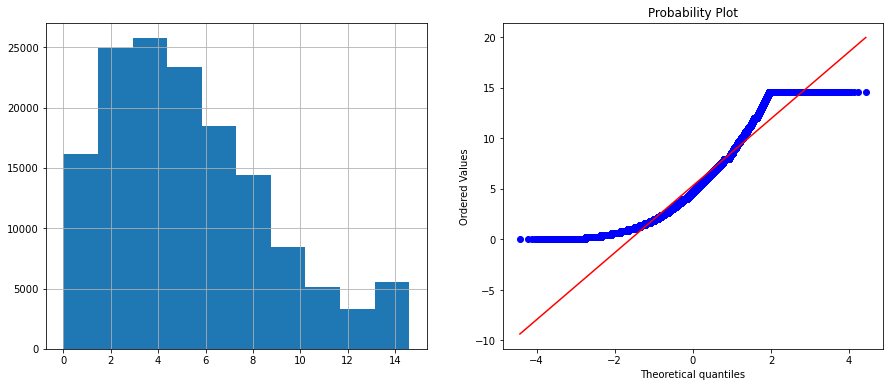

Sunshine


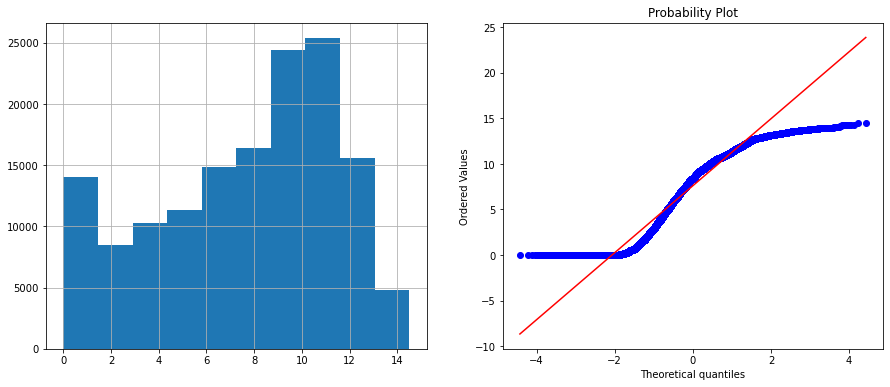

WindGustSpeed


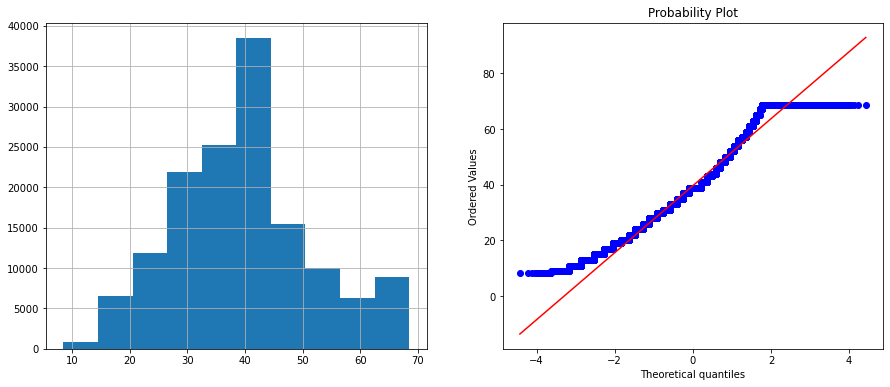

WindSpeed9am


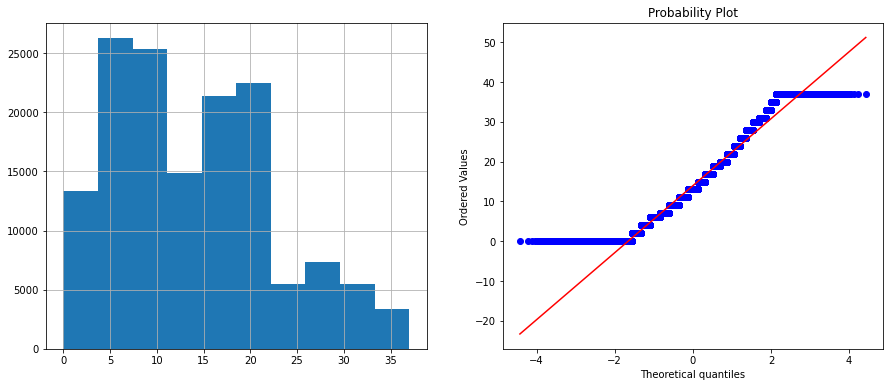

WindSpeed3pm


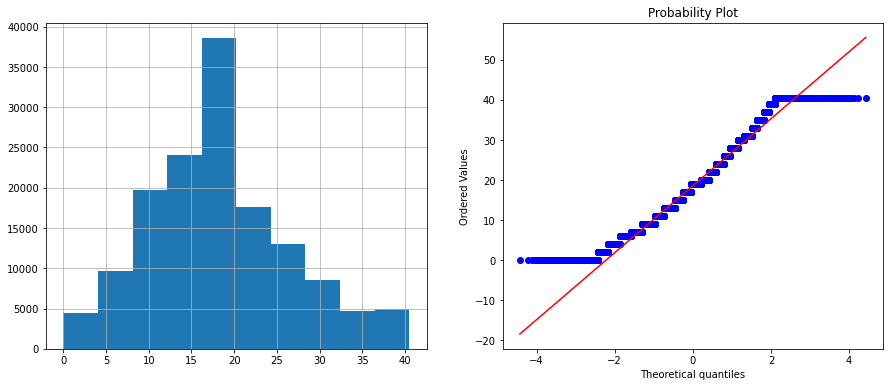

Humidity9am


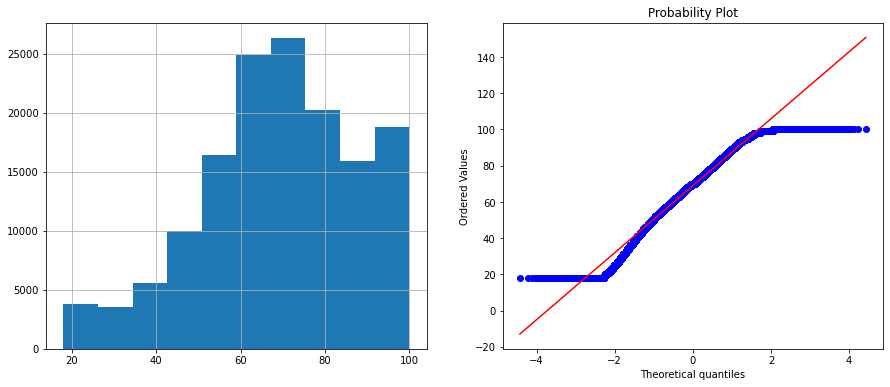

Humidity3pm


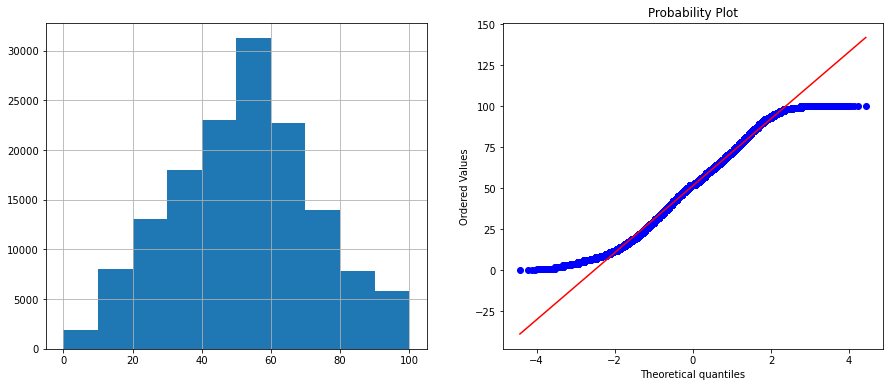

Pressure9am


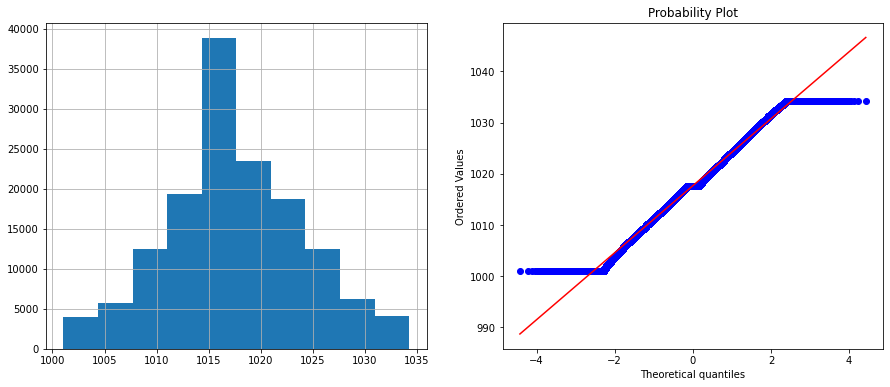

Pressure3pm


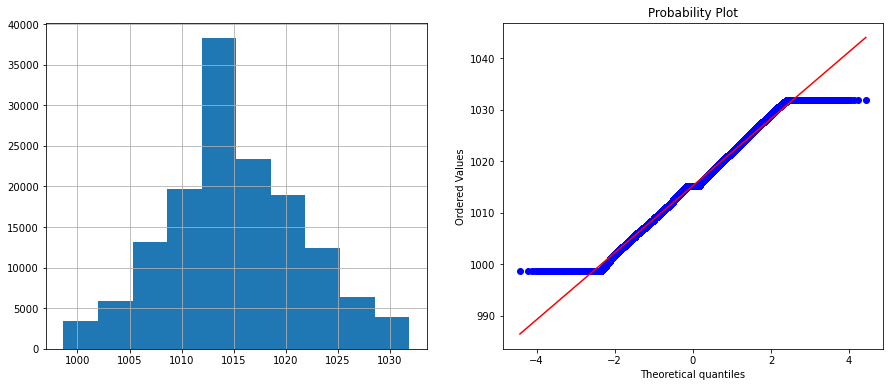

Temp9am


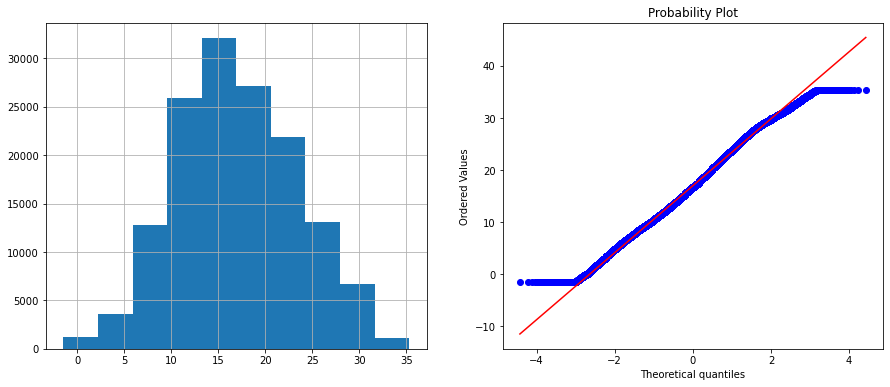

Temp3pm


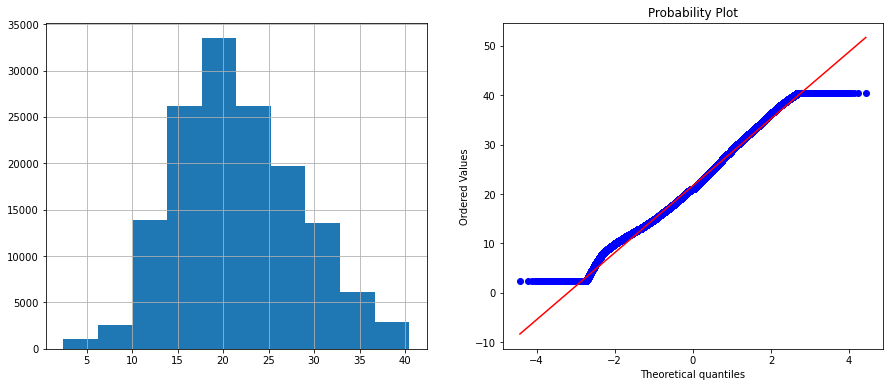

In [95]:
for feature in continuous_feature:
    print(feature)
    plt.figure(figsize=(15,6))
    plt.subplot(1, 2, 1)
    df[feature].hist()
    plt.subplot(1, 2, 2)
    stats.probplot(df[feature], dist="norm", plot=plt)
    plt.show()

In [96]:
df.to_csv("preprocessed_1.csv", index=False)

In [99]:
## Splitting the data
X = df.drop(["RainTomorrow","Date"],axis=1)
Y=df["RainTomorrow"]

In [100]:
X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size =0.2, stratify = Y, random_state = 0)

In [101]:
sm=SMOTE(random_state=0)
X_train_res,y_train_res=sm.fit_resample(X_train,y_train)
print("The number of classes before fit {}".format(Counter(y_train)))
print("The number of classes after fit {}".format(Counter(y_train_res)))

The number of classes before fit Counter({0: 90866, 1: 25502})
The number of classes after fit Counter({0: 90866, 1: 90866})


In [102]:
cat=CatBoostClassifier(iterations=2000,eval_metric="AUC")
cat.fit(X_train_res,y_train_res)

Learning rate set to 0.050311
0:	total: 228ms	remaining: 7m 34s
1:	total: 406ms	remaining: 6m 45s
2:	total: 524ms	remaining: 5m 48s
3:	total: 638ms	remaining: 5m 18s
4:	total: 778ms	remaining: 5m 10s
5:	total: 866ms	remaining: 4m 47s
6:	total: 937ms	remaining: 4m 26s
7:	total: 1.02s	remaining: 4m 15s
8:	total: 1.1s	remaining: 4m 4s
9:	total: 1.17s	remaining: 3m 53s
10:	total: 1.29s	remaining: 3m 52s
11:	total: 1.36s	remaining: 3m 46s
12:	total: 1.42s	remaining: 3m 37s
13:	total: 1.5s	remaining: 3m 32s
14:	total: 1.59s	remaining: 3m 30s
15:	total: 1.65s	remaining: 3m 24s
16:	total: 1.71s	remaining: 3m 19s
17:	total: 1.77s	remaining: 3m 14s
18:	total: 1.85s	remaining: 3m 13s
19:	total: 1.94s	remaining: 3m 11s
20:	total: 1.99s	remaining: 3m 7s
21:	total: 2.05s	remaining: 3m 4s
22:	total: 2.11s	remaining: 3m 1s
23:	total: 2.18s	remaining: 2m 59s
24:	total: 2.26s	remaining: 2m 58s
25:	total: 2.34s	remaining: 2m 57s
26:	total: 2.4s	remaining: 2m 55s
27:	total: 2.47s	remaining: 2m 53s
28:	tot

231:	total: 17.2s	remaining: 2m 11s
232:	total: 17.4s	remaining: 2m 11s
233:	total: 17.5s	remaining: 2m 11s
234:	total: 17.5s	remaining: 2m 11s
235:	total: 17.6s	remaining: 2m 11s
236:	total: 17.6s	remaining: 2m 11s
237:	total: 17.7s	remaining: 2m 11s
238:	total: 17.8s	remaining: 2m 11s
239:	total: 18s	remaining: 2m 11s
240:	total: 18.1s	remaining: 2m 12s
241:	total: 18.3s	remaining: 2m 12s
242:	total: 18.5s	remaining: 2m 13s
243:	total: 18.6s	remaining: 2m 13s
244:	total: 18.7s	remaining: 2m 13s
245:	total: 18.8s	remaining: 2m 13s
246:	total: 18.8s	remaining: 2m 13s
247:	total: 18.9s	remaining: 2m 13s
248:	total: 19.1s	remaining: 2m 14s
249:	total: 19.2s	remaining: 2m 14s
250:	total: 19.3s	remaining: 2m 14s
251:	total: 19.4s	remaining: 2m 14s
252:	total: 19.4s	remaining: 2m 14s
253:	total: 19.5s	remaining: 2m 14s
254:	total: 19.6s	remaining: 2m 13s
255:	total: 19.6s	remaining: 2m 13s
256:	total: 19.7s	remaining: 2m 13s
257:	total: 19.7s	remaining: 2m 13s
258:	total: 19.8s	remaining: 2

461:	total: 40.2s	remaining: 2m 13s
462:	total: 40.3s	remaining: 2m 13s
463:	total: 40.4s	remaining: 2m 13s
464:	total: 40.5s	remaining: 2m 13s
465:	total: 40.6s	remaining: 2m 13s
466:	total: 40.7s	remaining: 2m 13s
467:	total: 40.8s	remaining: 2m 13s
468:	total: 40.9s	remaining: 2m 13s
469:	total: 40.9s	remaining: 2m 13s
470:	total: 41s	remaining: 2m 13s
471:	total: 41s	remaining: 2m 12s
472:	total: 41.1s	remaining: 2m 12s
473:	total: 41.2s	remaining: 2m 12s
474:	total: 41.2s	remaining: 2m 12s
475:	total: 41.3s	remaining: 2m 12s
476:	total: 41.3s	remaining: 2m 11s
477:	total: 41.4s	remaining: 2m 11s
478:	total: 41.4s	remaining: 2m 11s
479:	total: 41.5s	remaining: 2m 11s
480:	total: 41.5s	remaining: 2m 11s
481:	total: 41.6s	remaining: 2m 11s
482:	total: 41.6s	remaining: 2m 10s
483:	total: 41.7s	remaining: 2m 10s
484:	total: 41.8s	remaining: 2m 10s
485:	total: 41.8s	remaining: 2m 10s
486:	total: 41.9s	remaining: 2m 10s
487:	total: 41.9s	remaining: 2m 9s
488:	total: 42s	remaining: 2m 9s


694:	total: 56.9s	remaining: 1m 46s
695:	total: 57s	remaining: 1m 46s
696:	total: 57.1s	remaining: 1m 46s
697:	total: 57.2s	remaining: 1m 46s
698:	total: 57.2s	remaining: 1m 46s
699:	total: 57.3s	remaining: 1m 46s
700:	total: 57.3s	remaining: 1m 46s
701:	total: 57.4s	remaining: 1m 46s
702:	total: 57.4s	remaining: 1m 45s
703:	total: 57.5s	remaining: 1m 45s
704:	total: 57.5s	remaining: 1m 45s
705:	total: 57.6s	remaining: 1m 45s
706:	total: 57.6s	remaining: 1m 45s
707:	total: 57.7s	remaining: 1m 45s
708:	total: 57.8s	remaining: 1m 45s
709:	total: 57.8s	remaining: 1m 45s
710:	total: 57.9s	remaining: 1m 44s
711:	total: 57.9s	remaining: 1m 44s
712:	total: 58s	remaining: 1m 44s
713:	total: 58.1s	remaining: 1m 44s
714:	total: 58.2s	remaining: 1m 44s
715:	total: 58.3s	remaining: 1m 44s
716:	total: 58.3s	remaining: 1m 44s
717:	total: 58.4s	remaining: 1m 44s
718:	total: 58.5s	remaining: 1m 44s
719:	total: 58.6s	remaining: 1m 44s
720:	total: 58.6s	remaining: 1m 44s
721:	total: 58.7s	remaining: 1m 

922:	total: 1m 14s	remaining: 1m 26s
923:	total: 1m 14s	remaining: 1m 26s
924:	total: 1m 14s	remaining: 1m 26s
925:	total: 1m 14s	remaining: 1m 26s
926:	total: 1m 14s	remaining: 1m 26s
927:	total: 1m 14s	remaining: 1m 26s
928:	total: 1m 14s	remaining: 1m 26s
929:	total: 1m 14s	remaining: 1m 26s
930:	total: 1m 14s	remaining: 1m 25s
931:	total: 1m 14s	remaining: 1m 25s
932:	total: 1m 15s	remaining: 1m 25s
933:	total: 1m 15s	remaining: 1m 25s
934:	total: 1m 15s	remaining: 1m 25s
935:	total: 1m 15s	remaining: 1m 25s
936:	total: 1m 15s	remaining: 1m 25s
937:	total: 1m 15s	remaining: 1m 25s
938:	total: 1m 15s	remaining: 1m 25s
939:	total: 1m 15s	remaining: 1m 25s
940:	total: 1m 15s	remaining: 1m 25s
941:	total: 1m 15s	remaining: 1m 25s
942:	total: 1m 15s	remaining: 1m 25s
943:	total: 1m 15s	remaining: 1m 24s
944:	total: 1m 15s	remaining: 1m 24s
945:	total: 1m 16s	remaining: 1m 24s
946:	total: 1m 16s	remaining: 1m 24s
947:	total: 1m 16s	remaining: 1m 24s
948:	total: 1m 16s	remaining: 1m 24s
9

1142:	total: 1m 30s	remaining: 1m 7s
1143:	total: 1m 30s	remaining: 1m 7s
1144:	total: 1m 30s	remaining: 1m 7s
1145:	total: 1m 30s	remaining: 1m 7s
1146:	total: 1m 30s	remaining: 1m 7s
1147:	total: 1m 30s	remaining: 1m 7s
1148:	total: 1m 30s	remaining: 1m 7s
1149:	total: 1m 30s	remaining: 1m 7s
1150:	total: 1m 30s	remaining: 1m 6s
1151:	total: 1m 30s	remaining: 1m 6s
1152:	total: 1m 30s	remaining: 1m 6s
1153:	total: 1m 30s	remaining: 1m 6s
1154:	total: 1m 30s	remaining: 1m 6s
1155:	total: 1m 31s	remaining: 1m 6s
1156:	total: 1m 31s	remaining: 1m 6s
1157:	total: 1m 31s	remaining: 1m 6s
1158:	total: 1m 31s	remaining: 1m 6s
1159:	total: 1m 31s	remaining: 1m 6s
1160:	total: 1m 31s	remaining: 1m 5s
1161:	total: 1m 31s	remaining: 1m 5s
1162:	total: 1m 31s	remaining: 1m 5s
1163:	total: 1m 31s	remaining: 1m 5s
1164:	total: 1m 31s	remaining: 1m 5s
1165:	total: 1m 31s	remaining: 1m 5s
1166:	total: 1m 31s	remaining: 1m 5s
1167:	total: 1m 31s	remaining: 1m 5s
1168:	total: 1m 31s	remaining: 1m 5s
1

1366:	total: 1m 46s	remaining: 49.1s
1367:	total: 1m 46s	remaining: 49s
1368:	total: 1m 46s	remaining: 48.9s
1369:	total: 1m 46s	remaining: 48.9s
1370:	total: 1m 46s	remaining: 48.8s
1371:	total: 1m 46s	remaining: 48.7s
1372:	total: 1m 46s	remaining: 48.6s
1373:	total: 1m 46s	remaining: 48.5s
1374:	total: 1m 46s	remaining: 48.5s
1375:	total: 1m 46s	remaining: 48.4s
1376:	total: 1m 46s	remaining: 48.3s
1377:	total: 1m 46s	remaining: 48.2s
1378:	total: 1m 46s	remaining: 48.1s
1379:	total: 1m 46s	remaining: 48s
1380:	total: 1m 46s	remaining: 47.9s
1381:	total: 1m 47s	remaining: 47.9s
1382:	total: 1m 47s	remaining: 47.8s
1383:	total: 1m 47s	remaining: 47.7s
1384:	total: 1m 47s	remaining: 47.6s
1385:	total: 1m 47s	remaining: 47.5s
1386:	total: 1m 47s	remaining: 47.4s
1387:	total: 1m 47s	remaining: 47.3s
1388:	total: 1m 47s	remaining: 47.2s
1389:	total: 1m 47s	remaining: 47.2s
1390:	total: 1m 47s	remaining: 47.1s
1391:	total: 1m 47s	remaining: 47s
1392:	total: 1m 47s	remaining: 46.9s
1393:	t

1592:	total: 2m 1s	remaining: 31.1s
1593:	total: 2m 1s	remaining: 31s
1594:	total: 2m 1s	remaining: 30.9s
1595:	total: 2m 1s	remaining: 30.8s
1596:	total: 2m 1s	remaining: 30.8s
1597:	total: 2m 2s	remaining: 30.7s
1598:	total: 2m 2s	remaining: 30.6s
1599:	total: 2m 2s	remaining: 30.5s
1600:	total: 2m 2s	remaining: 30.5s
1601:	total: 2m 2s	remaining: 30.4s
1602:	total: 2m 2s	remaining: 30.3s
1603:	total: 2m 2s	remaining: 30.3s
1604:	total: 2m 2s	remaining: 30.2s
1605:	total: 2m 2s	remaining: 30.1s
1606:	total: 2m 2s	remaining: 30s
1607:	total: 2m 2s	remaining: 29.9s
1608:	total: 2m 2s	remaining: 29.9s
1609:	total: 2m 2s	remaining: 29.8s
1610:	total: 2m 3s	remaining: 29.7s
1611:	total: 2m 3s	remaining: 29.6s
1612:	total: 2m 3s	remaining: 29.5s
1613:	total: 2m 3s	remaining: 29.5s
1614:	total: 2m 3s	remaining: 29.4s
1615:	total: 2m 3s	remaining: 29.3s
1616:	total: 2m 3s	remaining: 29.2s
1617:	total: 2m 3s	remaining: 29.1s
1618:	total: 2m 3s	remaining: 29.1s
1619:	total: 2m 3s	remaining: 29

1819:	total: 2m 18s	remaining: 13.7s
1820:	total: 2m 18s	remaining: 13.6s
1821:	total: 2m 18s	remaining: 13.5s
1822:	total: 2m 18s	remaining: 13.4s
1823:	total: 2m 18s	remaining: 13.4s
1824:	total: 2m 18s	remaining: 13.3s
1825:	total: 2m 18s	remaining: 13.2s
1826:	total: 2m 18s	remaining: 13.1s
1827:	total: 2m 18s	remaining: 13.1s
1828:	total: 2m 18s	remaining: 13s
1829:	total: 2m 18s	remaining: 12.9s
1830:	total: 2m 18s	remaining: 12.8s
1831:	total: 2m 19s	remaining: 12.7s
1832:	total: 2m 19s	remaining: 12.7s
1833:	total: 2m 19s	remaining: 12.6s
1834:	total: 2m 19s	remaining: 12.5s
1835:	total: 2m 19s	remaining: 12.4s
1836:	total: 2m 19s	remaining: 12.4s
1837:	total: 2m 19s	remaining: 12.3s
1838:	total: 2m 19s	remaining: 12.2s
1839:	total: 2m 19s	remaining: 12.1s
1840:	total: 2m 19s	remaining: 12.1s
1841:	total: 2m 19s	remaining: 12s
1842:	total: 2m 19s	remaining: 11.9s
1843:	total: 2m 19s	remaining: 11.8s
1844:	total: 2m 19s	remaining: 11.7s
1845:	total: 2m 19s	remaining: 11.7s
1846:

In [103]:
y_pred = cat.predict(X_test)
print(confusion_matrix(y_test,y_pred))
print(accuracy_score(y_test,y_pred))
print(classification_report(y_test,y_pred))

[[21518  1199]
 [ 2783  3592]]
0.863123882854393
              precision    recall  f1-score   support

           0       0.89      0.95      0.92     22717
           1       0.75      0.56      0.64      6375

    accuracy                           0.86     29092
   macro avg       0.82      0.76      0.78     29092
weighted avg       0.86      0.86      0.86     29092



0.7553355619485105

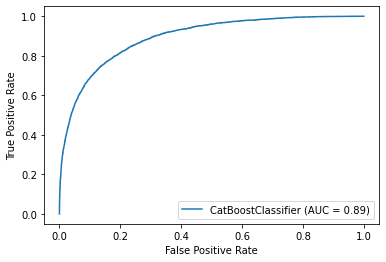

In [104]:
metrics.plot_roc_curve(cat,X_test,y_test)
metrics.roc_auc_score(y_test,y_pred,average=None)

In [105]:
rfc=RandomForestClassifier()
rfc.fit(X_train_res,y_train_res)

RandomForestClassifier()

In [106]:
y_pred1 = rfc.predict(X_test)
print(confusion_matrix(y_test,y_pred1))
print(accuracy_score(y_test,y_pred1))
print(classification_report(y_test,y_pred1))

[[20632  2085]
 [ 2465  3910]]
0.8435996150144369
              precision    recall  f1-score   support

           0       0.89      0.91      0.90     22717
           1       0.65      0.61      0.63      6375

    accuracy                           0.84     29092
   macro avg       0.77      0.76      0.77     29092
weighted avg       0.84      0.84      0.84     29092



0.7607759240510044

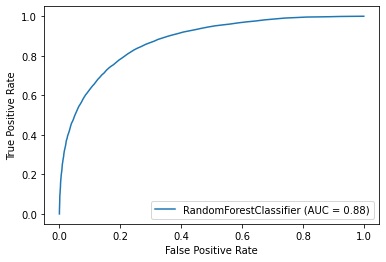

In [107]:
metrics.plot_roc_curve(rfc, X_test, y_test)
metrics.roc_auc_score(y_test, y_pred1, average=None) 

In [108]:
log_reg = LogisticRegression()
log_reg.fit(X_train_res,y_train_res)

C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [109]:
y_pred2 = log_reg.predict(X_test)
print(confusion_matrix(y_test,y_pred2))
print(accuracy_score(y_test,y_pred2))
print(classification_report(y_test,y_pred2))

[[17598  5119]
 [ 1519  4856]]
0.7718273064760072
              precision    recall  f1-score   support

           0       0.92      0.77      0.84     22717
           1       0.49      0.76      0.59      6375

    accuracy                           0.77     29092
   macro avg       0.70      0.77      0.72     29092
weighted avg       0.83      0.77      0.79     29092



0.7681938187433269

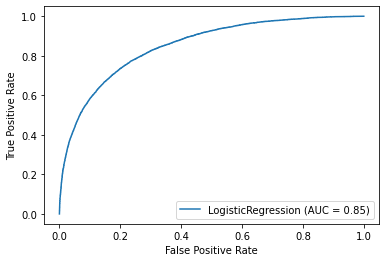

In [110]:
metrics.plot_roc_curve(log_reg, X_test, y_test)
metrics.roc_auc_score(y_test, y_pred2, average=None) 

In [111]:
gnb = GaussianNB()
gnb.fit(X_train_res, y_train_res)

GaussianNB()

In [112]:
y_pred3 = gnb.predict(X_test)
print(confusion_matrix(y_test,y_pred3))
print(accuracy_score(y_test,y_pred3))
print(classification_report(y_test,y_pred3))

[[17078  5639]
 [ 1661  4714]]
0.7490719098033823
              precision    recall  f1-score   support

           0       0.91      0.75      0.82     22717
           1       0.46      0.74      0.56      6375

    accuracy                           0.75     29092
   macro avg       0.68      0.75      0.69     29092
weighted avg       0.81      0.75      0.77     29092



0.7456113906230715

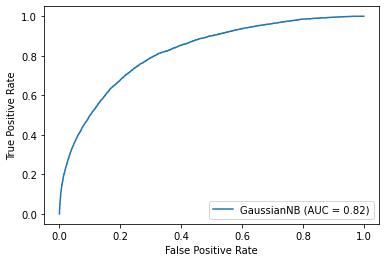

In [113]:
metrics.plot_roc_curve(gnb, X_test, y_test)
metrics.roc_auc_score(y_test, y_pred3, average=None) 

In [114]:
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train_res, y_train_res)

KNeighborsClassifier(n_neighbors=3)

In [115]:
y_pred4 = knn.predict(X_test)
print(confusion_matrix(y_test,y_pred4))
print(accuracy_score(y_test,y_pred4))
print(classification_report(y_test,y_pred4))

[[17306  5411]
 [ 1770  4605]]
0.7531623814106971
              precision    recall  f1-score   support

           0       0.91      0.76      0.83     22717
           1       0.46      0.72      0.56      6375

    accuracy                           0.75     29092
   macro avg       0.68      0.74      0.70     29092
weighted avg       0.81      0.75      0.77     29092



0.7420806392724806

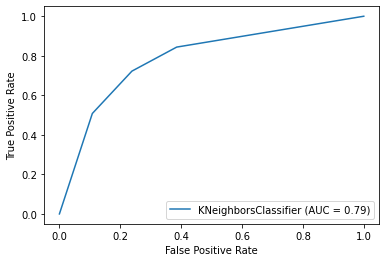

In [116]:
metrics.plot_roc_curve(knn, X_test, y_test)
metrics.roc_auc_score(y_test, y_pred4, average=None) 

In [117]:
xgb = XGBClassifier()
xgb.fit(X_train_res, y_train_res)

C:\Users\Lenovo\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:23:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=4, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [118]:
y_pred5 = xgb.predict(X_test)
print(confusion_matrix(y_test,y_pred5))
print(accuracy_score(y_test,y_pred5))
print(classification_report(y_test,y_pred5))

[[21377  1340]
 [ 2831  3544]]
0.8566272514780696
              precision    recall  f1-score   support

           0       0.88      0.94      0.91     22717
           1       0.73      0.56      0.63      6375

    accuracy                           0.86     29092
   macro avg       0.80      0.75      0.77     29092
weighted avg       0.85      0.86      0.85     29092



0.74846745332812

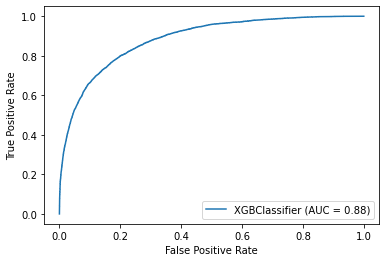

In [119]:
metrics.plot_roc_curve(xgb, X_test, y_test)
metrics.roc_auc_score(y_test, y_pred5, average=None) 

In [120]:
svc = SVC()
svc.fit(X_train_res, y_train_res)

SVC()

In [121]:
y_pred6 = svc.predict(X_test)
print(confusion_matrix(y_test,y_pred6))
print(accuracy_score(y_test,y_pred6))
print(classification_report(y_test,y_pred6))

[[17824  4893]
 [ 1594  4781]]
0.7770177368348687
              precision    recall  f1-score   support

           0       0.92      0.78      0.85     22717
           1       0.49      0.75      0.60      6375

    accuracy                           0.78     29092
   macro avg       0.71      0.77      0.72     29092
weighted avg       0.83      0.78      0.79     29092



0.7672857141624093

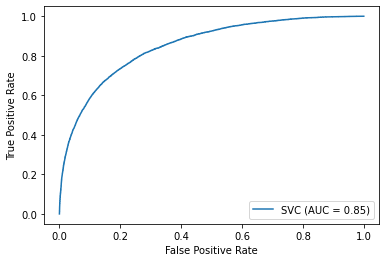

In [122]:
metrics.plot_roc_curve(svc, X_test, y_test)
metrics.roc_auc_score(y_test, y_pred6, average=None) 

In [126]:
#joblib.dump(rfc,"rfc.pkl")
#joblib.dump(cat, "cat.pkl")
#joblib.dump(log_reg, "logreg.pkl")
#joblib.dump(gnb, "gnb.pkl")
#joblib.dump(knn, "knn.pkl")
#joblib.dump(svc, "svc.pkl")
#joblib.dump(xgb, "xgb.pkl")

['xgb.pkl']